<a href="https://colab.research.google.com/github/Zuoyu2524/Cycle-GAN/blob/main/CycleGans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img
src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg"
WIDTH=235 HEIGHT=180>

<div align='center' >

<font size="8"> Final Project of Class Deep Learning</font>

<font size="5"> Students Name: Zuoyu Zhang and Xingyuan Kang</font>
</div>


**Part1 Data pre-processing and importing**

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


In [ ]:
import numpy as np
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision.transforms import transforms
from pathlib import Path
from torchvision import datasets

In [ ]:
class MyDataset(Dataset):
    def __init__(self, root, transform=None):
        self.transform = transforms.Compose([
                transforms.Resize((32,32)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
            ])
        images_path = Path(root)

        images_list = list(images_path.glob('*.jpg')) # list(images_path.glob('*.png'))
        images_list_str = [ str(x) for x in images_list ]
        self.images = images_list_str


    def __getitem__(self, item):
        image_path = self.images[item]

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #transform to the RGB
        #At this point the image is in the order H,W,C, so the following needs to be transformed into: C, H, W
        #Normalize [0, 1] to be consistent with the data read by PIL
        image = torch.from_numpy(image).permute(2, 0, 1)/255

        label = 1 if 'dog' in image_path.split('\\')[-1] else 0 # 这是一个label的示例，可自定义
        return image, label

    def __len__(self):
        return len(self.images)

In [ ]:
def get_loader_fashion(image_size, batch_size, num_workers):
    """Builds and returns Dataloader for Fashion MNIST dataset."""
    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5), (0.5))])


    Fashionmnist = datasets.FashionMNIST(root='./Fashionmnist', download=True, transform=transform)


    Fashionmnist_loader = torch.utils.data.DataLoader(dataset=Fashionmnist,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=True,
                          num_workers=num_workers)
    return Fashionmnist_loader

In [ ]:
def get_loader(image_size, batch_size, num_workers):
    """Builds and returns Dataloader for MNIST and SVHN dataset."""
    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    transform1 = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize((0.5), (0.5))])

    svhn = datasets.SVHN(root='./svhn', download=True, transform=transform)
    mnist = datasets.MNIST(root='./mnist', download=True, transform=transform1)

    svhn_loader = torch.utils.data.DataLoader(dataset=svhn,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers)

    mnist_loader = torch.utils.data.DataLoader(dataset=mnist,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=num_workers)
    return svhn_loader, mnist_loader

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
import pickle
import numpy as np
import imageio
import cv2

from torch.autograd import Variable
from torch import optim

In [ ]:
#model hyper-parameters using for creating dataloder
image_size=32
num_workers=2
batch_size=64
#Initiate the hyper-parameters for modeling and training
use_reconst_loss = True
use_labels = False
num_classes = 10
beta1 = 0.5
beta2 = 0.999
g_conv_dim = 64
d_conv_dim = 64
train_iters = 60000
lr = 0.0002
log_step = 10
sample_step = 500

In [ ]:
def deconv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom deconvolutional layer for simplicity."""
    layers = []
    layers.append(nn.ConvTranspose2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

In [ ]:
def conv(c_in, c_out, k_size, stride=2, pad=1, bn=True):
    """Custom convolutional layer for simplicity."""
    layers = []
    layers.append(nn.Conv2d(c_in, c_out, k_size, stride, pad, bias=False))
    if bn:
        layers.append(nn.BatchNorm2d(c_out))
    return nn.Sequential(*layers)

In [ ]:
class G12(nn.Module):
    """Generator for transfering from mnist to svhn"""
    def __init__(self, conv_dim=64):
        super(G12, self).__init__()
        # encoding blocks
        self.conv1 = conv(1, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)

        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)

        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 3, 4, bn=False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)

        out = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
        out = F.leaky_relu(self.conv4(out), 0.05)    # ( " )

        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = F.tanh(self.deconv2(out))              # (?, 3, 32, 32)
        return out

In [ ]:
class G21(nn.Module):
    """Generator for transfering from svhn to mnist"""
    def __init__(self, conv_dim=64):
        super(G21, self).__init__()
        # encoding blocks
        self.conv1 = conv(3, conv_dim, 4)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)

        # residual blocks
        self.conv3 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)
        self.conv4 = conv(conv_dim*2, conv_dim*2, 3, 1, 1)

        # decoding blocks
        self.deconv1 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv2 = deconv(conv_dim, 1, 4, bn=False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)      # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)    # (?, 128, 8, 8)

        out = F.leaky_relu(self.conv3(out), 0.05)    # ( " )
        out = F.leaky_relu(self.conv4(out), 0.05)    # ( " )

        out = F.leaky_relu(self.deconv1(out), 0.05)  # (?, 64, 16, 16)
        out = F.tanh(self.deconv2(out))              # (?, 1, 32, 32)
        return out

In [ ]:
class D1(nn.Module):
    """Discriminator for mnist."""
    def __init__(self, conv_dim=64, use_labels=False):
        super(D1, self).__init__()
        self.conv1 = conv(1, conv_dim, 4, bn=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 11 if use_labels else 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        out = self.fc(out).squeeze()
        return out

In [ ]:
class D2(nn.Module):
    """Discriminator for svhn."""
    def __init__(self, conv_dim=64, use_labels=False):
        super(D2, self).__init__()
        self.conv1 = conv(3, conv_dim, 4, bn=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        n_out = 11 if use_labels else 1
        self.fc = conv(conv_dim*4, n_out, 4, 1, 0, False)

    def forward(self, x):
        out = F.leaky_relu(self.conv1(x), 0.05)    # (?, 64, 16, 16)
        out = F.leaky_relu(self.conv2(out), 0.05)  # (?, 128, 8, 8)
        out = F.leaky_relu(self.conv3(out), 0.05)  # (?, 256, 4, 4)
        out = self.fc(out).squeeze()
        return out

In [ ]:
def str2bool(v):
    return v.lower() in ('true')

In [ ]:
def merge_images(batch_size, sources, targets, k=10):
    _, _, h, w = sources.shape
    row = int(np.sqrt(batch_size))
    merged = np.zeros([3, row*h, row*w*2])
    for idx, (s, t) in enumerate(zip(sources, targets)):
        i = idx // row
        j = idx % row
        merged[:, i*h:(i+1)*h, (j*2)*h:(j*2+1)*h] = s
        merged[:, i*h:(i+1)*h, (j*2+1)*h:(j*2+2)*h] = t
    return merged.transpose(1, 2, 0)

In [ ]:
def to_var(x):
    """Converts numpy to variable."""
    if torch.cuda.is_available():
         x = x.cuda()
    return Variable(x)

In [ ]:
def to_data(x):
    """Converts variable to numpy."""
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data.numpy()

In [ ]:
def reset_grad(g_optimizer, d_optimizer):
    """Zeros the gradient buffers."""
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
def train(svhn_loader, mnist_loader, train_iters=train_iters, use_labels=use_labels,
     use_reconst_loss=use_reconst_loss, num_classes=num_classes, g_conv_dim=g_conv_dim,
     d_conv_dim=d_conv_dim, lr=lr, beta1=beta1, beta2=beta2, log_step=log_step,
     sample_step=sample_step, sample_path=None, model_path=None):
    #============ data process ============#

    svhn_iter = iter(svhn_loader)
    mnist_iter = iter(mnist_loader)
    iter_per_epoch = min(len(svhn_iter), len(mnist_iter))

    #fixed mnist and svhn for sampling
    fixed_svhn = to_var(svhn_iter.next()[0])
    fixed_mnist = to_var(mnist_iter.next()[0])

    #============ model creation ============
    g12 = G12(conv_dim=g_conv_dim)
    g21 = G21(conv_dim=g_conv_dim)
    d1 = D1(conv_dim=d_conv_dim, use_labels=True)
    d2 = D2(conv_dim=d_conv_dim, use_labels=True)
    g_params = list(g12.parameters()) + list(g21.parameters())
    d_params = list(d1.parameters()) + list(d2.parameters())

    g_optimizer = optim.Adam(g_params, lr, [beta1, beta2])
    d_optimizer = optim.Adam(d_params, lr, [beta1, beta2])
    if torch.cuda.is_available():
            g12.cuda()
            g21.cuda()
            d1.cuda()
            d2.cuda()

    criterion = nn.CrossEntropyLoss()

    #============ train process ============#
    d_real_loss_list = []
    d_mnist_loss_list = []
    d_svhn_loss_list = []
    d_fake_loss_list =[]
    g_loss_list = []
    for step in range(train_iters+1):
      # reset data_iter for each epoch

      if (step+1) % iter_per_epoch == 0:
          mnist_iter = iter(mnist_loader)
          svhn_iter = iter(svhn_loader)

      # load svhn and mnist dataset
      svhn, s_labels = svhn_iter.next()
      svhn, s_labels = to_var(svhn), to_var(s_labels).long().squeeze()
      mnist, m_labels = mnist_iter.next()
      mnist, m_labels = to_var(mnist), to_var(m_labels)

      if use_labels:
          mnist_fake_labels = to_var(
              torch.Tensor([num_classes]*svhn.size(0)).long())
          svhn_fake_labels = to_var(
              torch.Tensor([num_classes]*mnist.size(0)).long())

      #============ train D ============#

      # train with real images
      reset_grad(g_optimizer, d_optimizer)
      out = d1(mnist)
      if use_labels:
          d1_loss = criterion(out, m_labels)
      else:
          d1_loss = torch.mean((out-1)**2)

      out = d2(svhn)
      if use_labels:
          d2_loss = criterion(out, s_labels)
      else:
          d2_loss = torch.mean((out-1)**2)

      d_mnist_loss = d1_loss
      d_svhn_loss = d2_loss
      d_real_loss = d1_loss + d2_loss
      d_real_loss.backward()
      d_optimizer.step()

      # train with fake images
      reset_grad(g_optimizer, d_optimizer)
      fake_svhn = g12(mnist)
      out = d2(fake_svhn)
      if use_labels:
          d2_loss = criterion(out, svhn_fake_labels)
      else:
          d2_loss = torch.mean(out**2)

      fake_mnist = g21(svhn)
      out = d1(fake_mnist)
      if use_labels:
          d1_loss = criterion(out, mnist_fake_labels)
      else:
          d1_loss = torch.mean(out**2)

      d_fake_loss = d1_loss + d2_loss
      d_fake_loss.backward()
      d_optimizer.step()

      #============ train G ============#

      # train mnist-svhn-mnist cycle
      reset_grad(g_optimizer, d_optimizer)
      fake_svhn = g12(mnist)
      out = d2(fake_svhn)
      reconst_mnist = g21(fake_svhn)
      if use_labels:
          g_loss = criterion(out, m_labels)
      else:
          g_loss = torch.mean((out-1)**2)

      if use_reconst_loss:
          g_loss += torch.mean((mnist - reconst_mnist)**2)

      g_loss.backward()
      g_optimizer.step()

      # train svhn-mnist-svhn cycle
      reset_grad(g_optimizer, d_optimizer)
      fake_mnist = g21(svhn)
      out = d1(fake_mnist)
      reconst_svhn = g12(fake_mnist)
      if use_labels:
          g_loss = criterion(out, s_labels)
      else:
          g_loss = torch.mean((out-1)**2)

      if use_reconst_loss:
          g_loss += torch.mean((svhn - reconst_svhn)**2)

      g_loss.backward()
      g_optimizer.step()

      # print the log info
      if (step+1) % log_step == 0:
          print('Step [%d/%d], d_real_loss: %.4f, d_mnist_loss: %.4f, d_svhn_loss: %.4f, '
                'd_fake_loss: %.4f, g_loss: %.4f'
                %(step+1, train_iters, d_real_loss.item(), d_mnist_loss.item(),
                  d_svhn_loss.item(), d_fake_loss.item(), g_loss.item()))
      d_real_loss_list.append(d_real_loss.item())
      d_mnist_loss_list.append(d_mnist_loss.item())
      d_svhn_loss_list.append(d_svhn_loss.item())
      d_fake_loss_list.append(d_fake_loss.item())
      g_loss_list.append(g_loss.item())

      # save the sampled images
      if (step+1) % sample_step == 0:
          fake_svhn = g12(fixed_mnist)
          fake_mnist = g21(fixed_svhn)

          mnist, fake_mnist = to_data(fixed_mnist), to_data(fake_mnist)
          svhn , fake_svhn = to_data(fixed_svhn), to_data(fake_svhn)

          merged = merge_images(batch_size, mnist, fake_svhn)
          path = os.path.join(sample_path, 'sample-%d-m-s.png' %(step+1))
          #scipy.misc.imsave(path, merged)
          imageio.imwrite(path, merged)
          print ('saved %s' %path)

          merged = merge_images(batch_size, svhn, fake_mnist)
          path = os.path.join(sample_path, 'sample-%d-s-m.png' %(step+1))
          #scipy.misc.imsave(path, merged)
          imageio.imwrite(path, merged)
          print ('saved %s' %path)


      if (step+1) % 5000 == 0:
          # save the model parameters for each epoch
          g12_path = os.path.join(model_path, 'g12-%d.pkl' %(step+1))
          g21_path = os.path.join(model_path, 'g21-%d.pkl' %(step+1))
          d1_path = os.path.join(model_path, 'd1-%d.pkl' %(step+1))
          d2_path = os.path.join(model_path, 'd2-%d.pkl' %(step+1))
          torch.save(g12.state_dict(), g12_path)
          torch.save(g21.state_dict(), g21_path)
          torch.save(d1.state_dict(), d1_path)
          torch.save(d2.state_dict(), d2_path)
    return d_real_loss_list, d_mnist_loss_list, d_svhn_loss_list, d_fake_loss_list, g_loss_list

In [ ]:
sample_path1 = './samples_mnist_svhn'
model_path1 = './models_mnist_svhn'

In [ ]:
if not os.path.exists(model_path1):
    os.makedirs(model_path1)
if not os.path.exists(sample_path1):
    os.makedirs(sample_path1)

In [ ]:
svhn_loader, mnist_loader = get_loader(image_size, batch_size, num_workers)

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [ ]:
d_real_loss_list, d_mnist_loss_list, d_svhn_loss_list, d_fake_loss_list, g_loss_list = train(svhn_loader, mnist_loader, sample_path=sample_path1, model_path=model_path1)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


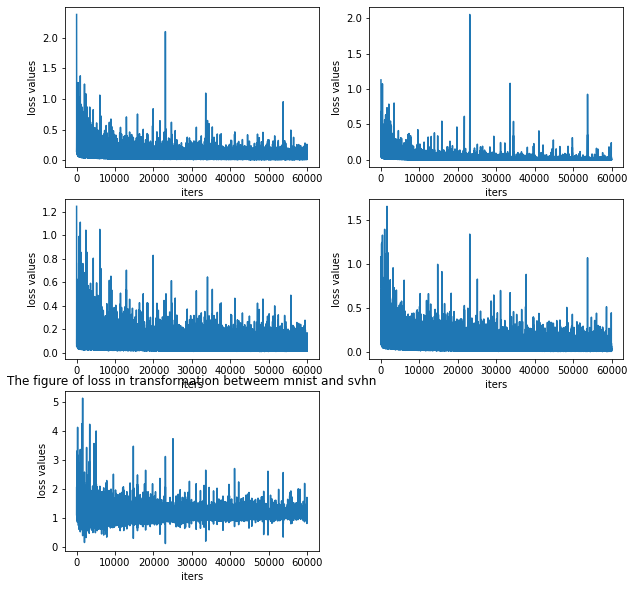

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
classes = [d_real_loss_list,d_mnist_loss_list,d_svhn_loss_list,d_fake_loss_list,g_loss_list]
labels = ['d_real_loss','d_mnist_loss','d_svhn_loss','d_fake_loss','g_loss']
# 第一幅图的下标从1开始，设置6张子图
for plt_index in range(1,6):
    # 往画布上添加子图：按三行二列，添加到下标为plt_index的位置
    ax = fig.add_subplot(3,2,plt_index)
    # 绘制对应的子图
    plt.plot(range(train_iters+1), classes[plt_index-1], label = labels[plt_index-1])
    plt.xlabel("iters")
    plt.ylabel("loss values")
    pass

# 显示画布
plt.title("The figure of loss in transformation betweem mnist and svhn")
plt.show()

**New dataset**

In [ ]:
from PIL import Image
import os.path
import glob
def convertjpg(jpgfile,outdir,width=32,height=32):
    img=Image.open(jpgfile)
    try:
        new_img=img.resize((width,height),Image.BILINEAR)
        new_img.save(os.path.join(outdir,os.path.basename(jpgfile)))
    except Exception as e:
        print(e)
for jpgfile in glob.glob("C:/Users/62300/Documents/MCE/deep learning/images/*.jpg"):
    convertjpg(jpgfile,"C:/Users/62300/Documents/MCE/deep learning/fashion_product_images_small")

In [ ]:
sample_path2 = './samples_fashion'
model_path2 = './models_fashion'

In [ ]:
if not os.path.exists(model_path2):
    os.makedirs(model_path2)
if not os.path.exists(sample_path2):
    os.makedirs(sample_path2)

In [ ]:
import zipfile
zip_file = zipfile.ZipFile('./fashion_product_images_small.zip')
zip_list = zip_file.namelist() # 得到压缩包里所有文件

for f in zip_list:
    zip_file.extract(f, '/content') # 循环解压文件到指定目录

zip_file.close() # 关闭文件，必须有，释放内存

In [ ]:
data1 = MyDataset("/content/fashion_product_images_small")

In [ ]:
len(data1)

44441

In [ ]:
fashion_loader = DataLoader(data1, batch_size=64, shuffle=True, drop_last=True)

In [ ]:
Fashionmnist_loader = get_loader_fashion(image_size, batch_size, num_workers)

In [ ]:
d_real_loss_list1, d_mnist_loss_list1, d_svhn_loss_list1, d_fake_loss_list1, g_loss_list1 = train(fashion_loader, Fashionmnist_loader, sample_path=sample_path2, model_path=model_path2)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Step [10/60000], d_real_loss: 0.3490, d_mnist_loss: 0.2323, d_svhn_loss: 0.1167, d_fake_loss: 0.3436, g_loss: 1.8219
Step [20/60000], d_real_loss: 0.3978, d_mnist_loss: 0.2418, d_svhn_loss: 0.1560, d_fake_loss: 0.4763, g_loss: 1.9687
Step [30/60000], d_real_loss: 0.2201, d_mnist_loss: 0.1860, d_svhn_loss: 0.0341, d_fake_loss: 0.4405, g_loss: 1.5503
Step [40/60000], d_real_loss: 0.3624, d_mnist_loss: 0.3110, d_svhn_loss: 0.0514, d_fake_loss: 0.4919, g_loss: 1.0345
Step [50/60000], d_real_loss: 0.6092, d_mnist_loss: 0.3142, d_svhn_loss: 0.2951, d_fake_loss: 0.6769, g_loss: 1.1208
Step [60/60000], d_real_loss: 0.4975, d_mnist_loss: 0.1993, d_svhn_loss: 0.2982, d_fake_loss: 0.4443, g_loss: 1.1618
Step [70/60000], d_real_loss: 0.5570, d_mnist_loss: 0.2014, d_svhn_loss: 0.3556, d_fake_loss: 0.4487, g_loss: 0.9268
Step [80/60000], d_real_loss: 0.5999, d_mnist_loss: 0.2472, d_svhn_loss: 0.3527, d_fake_loss: 0.3961, g_loss: 1.1336
Step [90/60000], d_real_loss: 0.6154, d_mnist_loss: 0.3881, d_sv

Step [500/60000], d_real_loss: 0.4906, d_mnist_loss: 0.2743, d_svhn_loss: 0.2163, d_fake_loss: 0.3368, g_loss: 0.8094
saved ./samples_fashion/sample-500-m-s.png
saved ./samples_fashion/sample-500-s-m.png
Step [510/60000], d_real_loss: 0.7473, d_mnist_loss: 0.1943, d_svhn_loss: 0.5530, d_fake_loss: 0.3696, g_loss: 0.8469
Step [520/60000], d_real_loss: 0.3028, d_mnist_loss: 0.1810, d_svhn_loss: 0.1218, d_fake_loss: 0.1627, g_loss: 0.8897
Step [530/60000], d_real_loss: 0.2364, d_mnist_loss: 0.1923, d_svhn_loss: 0.0441, d_fake_loss: 0.3779, g_loss: 0.8025
Step [540/60000], d_real_loss: 0.3801, d_mnist_loss: 0.2738, d_svhn_loss: 0.1063, d_fake_loss: 0.4841, g_loss: 0.7890
Step [550/60000], d_real_loss: 0.3486, d_mnist_loss: 0.2270, d_svhn_loss: 0.1216, d_fake_loss: 0.2507, g_loss: 0.8809
Step [560/60000], d_real_loss: 0.3284, d_mnist_loss: 0.1743, d_svhn_loss: 0.1541, d_fake_loss: 0.2354, g_loss: 0.9022
Step [570/60000], d_real_loss: 0.2664, d_mnist_loss: 0.2118, d_svhn_loss: 0.0546, d_fake

Step [1000/60000], d_real_loss: 0.2044, d_mnist_loss: 0.1419, d_svhn_loss: 0.0625, d_fake_loss: 0.2342, g_loss: 1.0259


saved ./samples_fashion/sample-1000-m-s.png
saved ./samples_fashion/sample-1000-s-m.png
Step [1010/60000], d_real_loss: 0.1846, d_mnist_loss: 0.1067, d_svhn_loss: 0.0779, d_fake_loss: 0.2789, g_loss: 1.2433
Step [1020/60000], d_real_loss: 0.4139, d_mnist_loss: 0.1624, d_svhn_loss: 0.2515, d_fake_loss: 0.3045, g_loss: 1.2099
Step [1030/60000], d_real_loss: 0.2593, d_mnist_loss: 0.1641, d_svhn_loss: 0.0952, d_fake_loss: 0.2027, g_loss: 1.0766
Step [1040/60000], d_real_loss: 0.4952, d_mnist_loss: 0.2147, d_svhn_loss: 0.2805, d_fake_loss: 0.2487, g_loss: 1.0543
Step [1050/60000], d_real_loss: 0.3552, d_mnist_loss: 0.2254, d_svhn_loss: 0.1298, d_fake_loss: 0.2894, g_loss: 1.2292
Step [1060/60000], d_real_loss: 0.3046, d_mnist_loss: 0.2147, d_svhn_loss: 0.0899, d_fake_loss: 0.2443, g_loss: 1.0941
Step [1070/60000], d_real_loss: 0.2819, d_mnist_loss: 0.1761, d_svhn_loss: 0.1058, d_fake_loss: 0.3446, g_loss: 1.0746
Step [1080/60000], d_real_loss: 0.3445, d_mnist_loss: 0.1519, d_svhn_loss: 0.19

Step [1500/60000], d_real_loss: 0.2652, d_mnist_loss: 0.0995, d_svhn_loss: 0.1657, d_fake_loss: 0.1535, g_loss: 1.2289
saved ./samples_fashion/sample-1500-m-s.png
saved ./samples_fashion/sample-1500-s-m.png
Step [1510/60000], d_real_loss: 0.1577, d_mnist_loss: 0.0591, d_svhn_loss: 0.0986, d_fake_loss: 0.3816, g_loss: 1.4703
Step [1520/60000], d_real_loss: 0.1599, d_mnist_loss: 0.0900, d_svhn_loss: 0.0699, d_fake_loss: 0.1296, g_loss: 1.3303
Step [1530/60000], d_real_loss: 0.2289, d_mnist_loss: 0.1352, d_svhn_loss: 0.0938, d_fake_loss: 0.1135, g_loss: 1.0255
Step [1540/60000], d_real_loss: 0.2207, d_mnist_loss: 0.1498, d_svhn_loss: 0.0708, d_fake_loss: 0.1426, g_loss: 1.2456
Step [1550/60000], d_real_loss: 0.2898, d_mnist_loss: 0.1354, d_svhn_loss: 0.1544, d_fake_loss: 0.2325, g_loss: 1.8022
Step [1560/60000], d_real_loss: 0.2449, d_mnist_loss: 0.1719, d_svhn_loss: 0.0730, d_fake_loss: 0.0842, g_loss: 1.0232
Step [1570/60000], d_real_loss: 0.2237, d_mnist_loss: 0.0950, d_svhn_loss: 0.12

Step [2000/60000], d_real_loss: 0.2210, d_mnist_loss: 0.0570, d_svhn_loss: 0.1640, d_fake_loss: 0.0881, g_loss: 1.1563
saved ./samples_fashion/sample-2000-m-s.png
saved ./samples_fashion/sample-2000-s-m.png
Step [2010/60000], d_real_loss: 0.3712, d_mnist_loss: 0.0503, d_svhn_loss: 0.3209, d_fake_loss: 0.1319, g_loss: 1.3173
Step [2020/60000], d_real_loss: 0.3796, d_mnist_loss: 0.3026, d_svhn_loss: 0.0770, d_fake_loss: 0.3031, g_loss: 1.9868
Step [2030/60000], d_real_loss: 0.1651, d_mnist_loss: 0.0499, d_svhn_loss: 0.1152, d_fake_loss: 0.2740, g_loss: 1.1480
Step [2040/60000], d_real_loss: 0.1399, d_mnist_loss: 0.0464, d_svhn_loss: 0.0935, d_fake_loss: 0.3459, g_loss: 1.6348
Step [2050/60000], d_real_loss: 0.0994, d_mnist_loss: 0.0541, d_svhn_loss: 0.0453, d_fake_loss: 0.1755, g_loss: 1.4561
Step [2060/60000], d_real_loss: 0.1877, d_mnist_loss: 0.1418, d_svhn_loss: 0.0460, d_fake_loss: 0.1933, g_loss: 1.9495
Step [2070/60000], d_real_loss: 0.1987, d_mnist_loss: 0.0574, d_svhn_loss: 0.14

Step [2500/60000], d_real_loss: 0.1571, d_mnist_loss: 0.0583, d_svhn_loss: 0.0988, d_fake_loss: 0.1419, g_loss: 1.1003
saved ./samples_fashion/sample-2500-m-s.png
saved ./samples_fashion/sample-2500-s-m.png
Step [2510/60000], d_real_loss: 0.3670, d_mnist_loss: 0.2596, d_svhn_loss: 0.1073, d_fake_loss: 0.2257, g_loss: 1.2994
Step [2520/60000], d_real_loss: 0.1253, d_mnist_loss: 0.0555, d_svhn_loss: 0.0698, d_fake_loss: 0.1634, g_loss: 0.9578
Step [2530/60000], d_real_loss: 0.3000, d_mnist_loss: 0.0437, d_svhn_loss: 0.2563, d_fake_loss: 0.0612, g_loss: 1.0891
Step [2540/60000], d_real_loss: 0.3667, d_mnist_loss: 0.0429, d_svhn_loss: 0.3238, d_fake_loss: 0.1827, g_loss: 0.9744
Step [2550/60000], d_real_loss: 0.4482, d_mnist_loss: 0.3792, d_svhn_loss: 0.0690, d_fake_loss: 0.2619, g_loss: 1.1288
Step [2560/60000], d_real_loss: 0.2341, d_mnist_loss: 0.0406, d_svhn_loss: 0.1935, d_fake_loss: 0.1217, g_loss: 1.4314
Step [2570/60000], d_real_loss: 0.2085, d_mnist_loss: 0.1544, d_svhn_loss: 0.05

Step [3000/60000], d_real_loss: 0.2256, d_mnist_loss: 0.0312, d_svhn_loss: 0.1944, d_fake_loss: 0.2853, g_loss: 1.3859
saved ./samples_fashion/sample-3000-m-s.png
saved ./samples_fashion/sample-3000-s-m.png
Step [3010/60000], d_real_loss: 0.1199, d_mnist_loss: 0.0593, d_svhn_loss: 0.0607, d_fake_loss: 0.0850, g_loss: 1.1727
Step [3020/60000], d_real_loss: 0.0783, d_mnist_loss: 0.0246, d_svhn_loss: 0.0537, d_fake_loss: 0.0758, g_loss: 1.3412
Step [3030/60000], d_real_loss: 0.0785, d_mnist_loss: 0.0470, d_svhn_loss: 0.0315, d_fake_loss: 0.0558, g_loss: 1.1886
Step [3040/60000], d_real_loss: 0.0762, d_mnist_loss: 0.0287, d_svhn_loss: 0.0475, d_fake_loss: 0.0565, g_loss: 1.0837
Step [3050/60000], d_real_loss: 0.0844, d_mnist_loss: 0.0335, d_svhn_loss: 0.0508, d_fake_loss: 0.1167, g_loss: 1.6174
Step [3060/60000], d_real_loss: 0.2161, d_mnist_loss: 0.0711, d_svhn_loss: 0.1450, d_fake_loss: 0.1898, g_loss: 1.3331
Step [3070/60000], d_real_loss: 0.1453, d_mnist_loss: 0.0444, d_svhn_loss: 0.10

Step [3500/60000], d_real_loss: 0.4437, d_mnist_loss: 0.1474, d_svhn_loss: 0.2963, d_fake_loss: 0.2555, g_loss: 1.4985
saved ./samples_fashion/sample-3500-m-s.png
saved ./samples_fashion/sample-3500-s-m.png
Step [3510/60000], d_real_loss: 0.1008, d_mnist_loss: 0.0525, d_svhn_loss: 0.0483, d_fake_loss: 0.2142, g_loss: 1.3336
Step [3520/60000], d_real_loss: 0.2314, d_mnist_loss: 0.1213, d_svhn_loss: 0.1101, d_fake_loss: 0.1198, g_loss: 1.0872
Step [3530/60000], d_real_loss: 0.0966, d_mnist_loss: 0.0179, d_svhn_loss: 0.0787, d_fake_loss: 0.1238, g_loss: 1.2504
Step [3540/60000], d_real_loss: 0.1465, d_mnist_loss: 0.0416, d_svhn_loss: 0.1049, d_fake_loss: 0.1430, g_loss: 1.0015
Step [3550/60000], d_real_loss: 0.0646, d_mnist_loss: 0.0308, d_svhn_loss: 0.0338, d_fake_loss: 0.0705, g_loss: 1.1574
Step [3560/60000], d_real_loss: 0.0779, d_mnist_loss: 0.0245, d_svhn_loss: 0.0533, d_fake_loss: 0.0528, g_loss: 1.2391
Step [3570/60000], d_real_loss: 0.0911, d_mnist_loss: 0.0345, d_svhn_loss: 0.05

Step [4000/60000], d_real_loss: 0.1459, d_mnist_loss: 0.0653, d_svhn_loss: 0.0806, d_fake_loss: 0.1248, g_loss: 1.2038
saved ./samples_fashion/sample-4000-m-s.png
saved ./samples_fashion/sample-4000-s-m.png
Step [4010/60000], d_real_loss: 0.0613, d_mnist_loss: 0.0192, d_svhn_loss: 0.0421, d_fake_loss: 0.1201, g_loss: 1.2960
Step [4020/60000], d_real_loss: 0.0582, d_mnist_loss: 0.0234, d_svhn_loss: 0.0347, d_fake_loss: 0.0486, g_loss: 1.1979
Step [4030/60000], d_real_loss: 0.1767, d_mnist_loss: 0.0610, d_svhn_loss: 0.1157, d_fake_loss: 0.0709, g_loss: 1.0280
Step [4040/60000], d_real_loss: 0.0635, d_mnist_loss: 0.0220, d_svhn_loss: 0.0415, d_fake_loss: 0.1043, g_loss: 1.2336
Step [4050/60000], d_real_loss: 0.2202, d_mnist_loss: 0.1551, d_svhn_loss: 0.0651, d_fake_loss: 0.0755, g_loss: 1.0108
Step [4060/60000], d_real_loss: 0.0502, d_mnist_loss: 0.0212, d_svhn_loss: 0.0290, d_fake_loss: 0.1404, g_loss: 1.1445
Step [4070/60000], d_real_loss: 0.1905, d_mnist_loss: 0.0494, d_svhn_loss: 0.14

Step [4500/60000], d_real_loss: 0.0849, d_mnist_loss: 0.0494, d_svhn_loss: 0.0355, d_fake_loss: 0.1280, g_loss: 1.2189
saved ./samples_fashion/sample-4500-m-s.png
saved ./samples_fashion/sample-4500-s-m.png
Step [4510/60000], d_real_loss: 0.1097, d_mnist_loss: 0.0653, d_svhn_loss: 0.0444, d_fake_loss: 0.2399, g_loss: 1.5671
Step [4520/60000], d_real_loss: 0.1761, d_mnist_loss: 0.0359, d_svhn_loss: 0.1403, d_fake_loss: 0.9975, g_loss: 2.9674
Step [4530/60000], d_real_loss: 0.0957, d_mnist_loss: 0.0485, d_svhn_loss: 0.0472, d_fake_loss: 0.1735, g_loss: 1.2519
Step [4540/60000], d_real_loss: 0.0864, d_mnist_loss: 0.0287, d_svhn_loss: 0.0577, d_fake_loss: 0.0672, g_loss: 1.2970
Step [4550/60000], d_real_loss: 0.0652, d_mnist_loss: 0.0297, d_svhn_loss: 0.0355, d_fake_loss: 0.0687, g_loss: 0.9648
Step [4560/60000], d_real_loss: 0.1700, d_mnist_loss: 0.1272, d_svhn_loss: 0.0428, d_fake_loss: 0.1121, g_loss: 1.4425
Step [4570/60000], d_real_loss: 0.2482, d_mnist_loss: 0.1890, d_svhn_loss: 0.05

Step [5000/60000], d_real_loss: 0.0798, d_mnist_loss: 0.0537, d_svhn_loss: 0.0261, d_fake_loss: 0.1355, g_loss: 1.5250
saved ./samples_fashion/sample-5000-m-s.png
saved ./samples_fashion/sample-5000-s-m.png
Step [5010/60000], d_real_loss: 0.0552, d_mnist_loss: 0.0224, d_svhn_loss: 0.0328, d_fake_loss: 0.0457, g_loss: 1.1610
Step [5020/60000], d_real_loss: 0.1031, d_mnist_loss: 0.0329, d_svhn_loss: 0.0702, d_fake_loss: 0.0898, g_loss: 1.2215
Step [5030/60000], d_real_loss: 0.0561, d_mnist_loss: 0.0232, d_svhn_loss: 0.0328, d_fake_loss: 0.0556, g_loss: 1.2166
Step [5040/60000], d_real_loss: 0.0966, d_mnist_loss: 0.0467, d_svhn_loss: 0.0499, d_fake_loss: 0.2479, g_loss: 1.7013
Step [5050/60000], d_real_loss: 0.0493, d_mnist_loss: 0.0204, d_svhn_loss: 0.0289, d_fake_loss: 0.0999, g_loss: 1.4826
Step [5060/60000], d_real_loss: 0.4140, d_mnist_loss: 0.1754, d_svhn_loss: 0.2386, d_fake_loss: 0.3533, g_loss: 1.5553
Step [5070/60000], d_real_loss: 0.0905, d_mnist_loss: 0.0568, d_svhn_loss: 0.03

Step [5500/60000], d_real_loss: 0.0684, d_mnist_loss: 0.0323, d_svhn_loss: 0.0362, d_fake_loss: 0.1220, g_loss: 0.9745
saved ./samples_fashion/sample-5500-m-s.png
saved ./samples_fashion/sample-5500-s-m.png
Step [5510/60000], d_real_loss: 0.0986, d_mnist_loss: 0.0172, d_svhn_loss: 0.0814, d_fake_loss: 0.1122, g_loss: 0.9819
Step [5520/60000], d_real_loss: 0.1613, d_mnist_loss: 0.1283, d_svhn_loss: 0.0330, d_fake_loss: 0.1648, g_loss: 1.5090
Step [5530/60000], d_real_loss: 0.1169, d_mnist_loss: 0.0294, d_svhn_loss: 0.0874, d_fake_loss: 0.0630, g_loss: 1.0492
Step [5540/60000], d_real_loss: 0.1017, d_mnist_loss: 0.0189, d_svhn_loss: 0.0828, d_fake_loss: 0.1759, g_loss: 1.3142
Step [5550/60000], d_real_loss: 0.0756, d_mnist_loss: 0.0362, d_svhn_loss: 0.0394, d_fake_loss: 0.1100, g_loss: 1.3669
Step [5560/60000], d_real_loss: 0.0577, d_mnist_loss: 0.0322, d_svhn_loss: 0.0255, d_fake_loss: 0.1401, g_loss: 1.5502
Step [5570/60000], d_real_loss: 0.0613, d_mnist_loss: 0.0110, d_svhn_loss: 0.05

Step [6000/60000], d_real_loss: 0.0856, d_mnist_loss: 0.0469, d_svhn_loss: 0.0388, d_fake_loss: 0.1824, g_loss: 1.4971
saved ./samples_fashion/sample-6000-m-s.png
saved ./samples_fashion/sample-6000-s-m.png
Step [6010/60000], d_real_loss: 0.0595, d_mnist_loss: 0.0209, d_svhn_loss: 0.0386, d_fake_loss: 0.0771, g_loss: 1.2742
Step [6020/60000], d_real_loss: 0.1304, d_mnist_loss: 0.0519, d_svhn_loss: 0.0784, d_fake_loss: 0.0795, g_loss: 1.3008
Step [6030/60000], d_real_loss: 0.0517, d_mnist_loss: 0.0118, d_svhn_loss: 0.0399, d_fake_loss: 0.0502, g_loss: 1.2779
Step [6040/60000], d_real_loss: 0.1282, d_mnist_loss: 0.0262, d_svhn_loss: 0.1020, d_fake_loss: 0.0777, g_loss: 1.1354
Step [6050/60000], d_real_loss: 0.0858, d_mnist_loss: 0.0301, d_svhn_loss: 0.0557, d_fake_loss: 0.1104, g_loss: 1.4881
Step [6060/60000], d_real_loss: 0.1231, d_mnist_loss: 0.0207, d_svhn_loss: 0.1024, d_fake_loss: 0.1679, g_loss: 1.2856
Step [6070/60000], d_real_loss: 0.0928, d_mnist_loss: 0.0516, d_svhn_loss: 0.04

Step [6500/60000], d_real_loss: 0.1486, d_mnist_loss: 0.1150, d_svhn_loss: 0.0336, d_fake_loss: 0.3099, g_loss: 2.1055
saved ./samples_fashion/sample-6500-m-s.png
saved ./samples_fashion/sample-6500-s-m.png
Step [6510/60000], d_real_loss: 0.1102, d_mnist_loss: 0.0350, d_svhn_loss: 0.0752, d_fake_loss: 0.4989, g_loss: 1.3623
Step [6520/60000], d_real_loss: 0.0630, d_mnist_loss: 0.0237, d_svhn_loss: 0.0393, d_fake_loss: 0.1374, g_loss: 1.1423
Step [6530/60000], d_real_loss: 0.0962, d_mnist_loss: 0.0200, d_svhn_loss: 0.0761, d_fake_loss: 0.0736, g_loss: 1.3371
Step [6540/60000], d_real_loss: 0.1749, d_mnist_loss: 0.0857, d_svhn_loss: 0.0893, d_fake_loss: 0.0624, g_loss: 1.3289
Step [6550/60000], d_real_loss: 0.1239, d_mnist_loss: 0.0940, d_svhn_loss: 0.0299, d_fake_loss: 0.9461, g_loss: 2.0483
Step [6560/60000], d_real_loss: 0.0599, d_mnist_loss: 0.0302, d_svhn_loss: 0.0297, d_fake_loss: 0.0542, g_loss: 1.0689
Step [6570/60000], d_real_loss: 0.0597, d_mnist_loss: 0.0344, d_svhn_loss: 0.02

Step [7000/60000], d_real_loss: 0.0516, d_mnist_loss: 0.0183, d_svhn_loss: 0.0333, d_fake_loss: 0.0383, g_loss: 1.0629
saved ./samples_fashion/sample-7000-m-s.png
saved ./samples_fashion/sample-7000-s-m.png
Step [7010/60000], d_real_loss: 0.0556, d_mnist_loss: 0.0255, d_svhn_loss: 0.0301, d_fake_loss: 0.0522, g_loss: 1.1243
Step [7020/60000], d_real_loss: 0.0535, d_mnist_loss: 0.0281, d_svhn_loss: 0.0254, d_fake_loss: 0.0597, g_loss: 0.8956
Step [7030/60000], d_real_loss: 0.1062, d_mnist_loss: 0.0210, d_svhn_loss: 0.0851, d_fake_loss: 0.0572, g_loss: 1.0626
Step [7040/60000], d_real_loss: 0.0983, d_mnist_loss: 0.0473, d_svhn_loss: 0.0510, d_fake_loss: 0.1903, g_loss: 1.0411
Step [7050/60000], d_real_loss: 0.0481, d_mnist_loss: 0.0149, d_svhn_loss: 0.0333, d_fake_loss: 0.0469, g_loss: 1.2485
Step [7060/60000], d_real_loss: 0.0719, d_mnist_loss: 0.0366, d_svhn_loss: 0.0353, d_fake_loss: 0.0986, g_loss: 0.8753
Step [7070/60000], d_real_loss: 0.1428, d_mnist_loss: 0.0478, d_svhn_loss: 0.09

Step [7500/60000], d_real_loss: 0.0451, d_mnist_loss: 0.0134, d_svhn_loss: 0.0318, d_fake_loss: 0.1432, g_loss: 1.2181
saved ./samples_fashion/sample-7500-m-s.png
saved ./samples_fashion/sample-7500-s-m.png
Step [7510/60000], d_real_loss: 0.0508, d_mnist_loss: 0.0155, d_svhn_loss: 0.0353, d_fake_loss: 0.0493, g_loss: 1.3093
Step [7520/60000], d_real_loss: 0.0622, d_mnist_loss: 0.0216, d_svhn_loss: 0.0405, d_fake_loss: 0.1179, g_loss: 1.4212
Step [7530/60000], d_real_loss: 0.0546, d_mnist_loss: 0.0241, d_svhn_loss: 0.0305, d_fake_loss: 0.1028, g_loss: 1.3568
Step [7540/60000], d_real_loss: 0.1571, d_mnist_loss: 0.1261, d_svhn_loss: 0.0310, d_fake_loss: 0.1084, g_loss: 1.1885
Step [7550/60000], d_real_loss: 0.0438, d_mnist_loss: 0.0186, d_svhn_loss: 0.0252, d_fake_loss: 0.0562, g_loss: 1.1302
Step [7560/60000], d_real_loss: 0.0840, d_mnist_loss: 0.0283, d_svhn_loss: 0.0557, d_fake_loss: 0.0720, g_loss: 1.3573
Step [7570/60000], d_real_loss: 0.0769, d_mnist_loss: 0.0221, d_svhn_loss: 0.05

Step [8000/60000], d_real_loss: 0.0664, d_mnist_loss: 0.0196, d_svhn_loss: 0.0468, d_fake_loss: 0.0437, g_loss: 1.0770
saved ./samples_fashion/sample-8000-m-s.png
saved ./samples_fashion/sample-8000-s-m.png
Step [8010/60000], d_real_loss: 0.1078, d_mnist_loss: 0.0449, d_svhn_loss: 0.0629, d_fake_loss: 0.0914, g_loss: 0.9511
Step [8020/60000], d_real_loss: 0.2330, d_mnist_loss: 0.0211, d_svhn_loss: 0.2118, d_fake_loss: 0.0724, g_loss: 1.1277
Step [8030/60000], d_real_loss: 0.1821, d_mnist_loss: 0.0164, d_svhn_loss: 0.1657, d_fake_loss: 0.2547, g_loss: 1.0324
Step [8040/60000], d_real_loss: 0.0872, d_mnist_loss: 0.0445, d_svhn_loss: 0.0427, d_fake_loss: 0.0670, g_loss: 1.4684
Step [8050/60000], d_real_loss: 0.0818, d_mnist_loss: 0.0187, d_svhn_loss: 0.0630, d_fake_loss: 0.0458, g_loss: 1.1098
Step [8060/60000], d_real_loss: 0.0897, d_mnist_loss: 0.0637, d_svhn_loss: 0.0261, d_fake_loss: 0.0518, g_loss: 1.0230
Step [8070/60000], d_real_loss: 0.1511, d_mnist_loss: 0.1038, d_svhn_loss: 0.04

Step [8500/60000], d_real_loss: 0.0781, d_mnist_loss: 0.0323, d_svhn_loss: 0.0458, d_fake_loss: 0.0887, g_loss: 1.0955
saved ./samples_fashion/sample-8500-m-s.png
saved ./samples_fashion/sample-8500-s-m.png
Step [8510/60000], d_real_loss: 0.0572, d_mnist_loss: 0.0252, d_svhn_loss: 0.0320, d_fake_loss: 0.0748, g_loss: 0.9323
Step [8520/60000], d_real_loss: 0.0540, d_mnist_loss: 0.0187, d_svhn_loss: 0.0353, d_fake_loss: 0.0860, g_loss: 1.0591
Step [8530/60000], d_real_loss: 0.0777, d_mnist_loss: 0.0237, d_svhn_loss: 0.0539, d_fake_loss: 0.1210, g_loss: 1.3481
Step [8540/60000], d_real_loss: 0.1199, d_mnist_loss: 0.0172, d_svhn_loss: 0.1027, d_fake_loss: 0.0927, g_loss: 1.1402
Step [8550/60000], d_real_loss: 0.1143, d_mnist_loss: 0.0293, d_svhn_loss: 0.0850, d_fake_loss: 0.0446, g_loss: 1.1003
Step [8560/60000], d_real_loss: 0.2037, d_mnist_loss: 0.0445, d_svhn_loss: 0.1592, d_fake_loss: 0.1970, g_loss: 1.6987
Step [8570/60000], d_real_loss: 0.1503, d_mnist_loss: 0.0590, d_svhn_loss: 0.09

Step [9000/60000], d_real_loss: 0.0858, d_mnist_loss: 0.0141, d_svhn_loss: 0.0717, d_fake_loss: 0.0377, g_loss: 1.0821
saved ./samples_fashion/sample-9000-m-s.png
saved ./samples_fashion/sample-9000-s-m.png
Step [9010/60000], d_real_loss: 0.0998, d_mnist_loss: 0.0182, d_svhn_loss: 0.0815, d_fake_loss: 0.1673, g_loss: 1.2810
Step [9020/60000], d_real_loss: 0.1019, d_mnist_loss: 0.0482, d_svhn_loss: 0.0537, d_fake_loss: 0.1288, g_loss: 0.9540
Step [9030/60000], d_real_loss: 0.0735, d_mnist_loss: 0.0479, d_svhn_loss: 0.0256, d_fake_loss: 0.0640, g_loss: 1.0717
Step [9040/60000], d_real_loss: 0.0737, d_mnist_loss: 0.0439, d_svhn_loss: 0.0298, d_fake_loss: 0.0459, g_loss: 1.1532
Step [9050/60000], d_real_loss: 0.1024, d_mnist_loss: 0.0511, d_svhn_loss: 0.0513, d_fake_loss: 0.0548, g_loss: 1.1175
Step [9060/60000], d_real_loss: 0.1408, d_mnist_loss: 0.0387, d_svhn_loss: 0.1021, d_fake_loss: 0.1176, g_loss: 1.2923
Step [9070/60000], d_real_loss: 0.0408, d_mnist_loss: 0.0154, d_svhn_loss: 0.02

Step [9500/60000], d_real_loss: 0.0418, d_mnist_loss: 0.0122, d_svhn_loss: 0.0295, d_fake_loss: 0.0719, g_loss: 1.1393
saved ./samples_fashion/sample-9500-m-s.png
saved ./samples_fashion/sample-9500-s-m.png
Step [9510/60000], d_real_loss: 0.1391, d_mnist_loss: 0.0429, d_svhn_loss: 0.0962, d_fake_loss: 0.0714, g_loss: 1.2050
Step [9520/60000], d_real_loss: 0.1561, d_mnist_loss: 0.0231, d_svhn_loss: 0.1330, d_fake_loss: 0.1653, g_loss: 1.3159
Step [9530/60000], d_real_loss: 0.0534, d_mnist_loss: 0.0225, d_svhn_loss: 0.0309, d_fake_loss: 0.0386, g_loss: 1.1962
Step [9540/60000], d_real_loss: 0.0513, d_mnist_loss: 0.0236, d_svhn_loss: 0.0277, d_fake_loss: 0.0381, g_loss: 1.2150
Step [9550/60000], d_real_loss: 0.1789, d_mnist_loss: 0.0488, d_svhn_loss: 0.1301, d_fake_loss: 0.0513, g_loss: 1.1006
Step [9560/60000], d_real_loss: 0.0845, d_mnist_loss: 0.0369, d_svhn_loss: 0.0476, d_fake_loss: 0.0598, g_loss: 1.1184
Step [9570/60000], d_real_loss: 0.0612, d_mnist_loss: 0.0211, d_svhn_loss: 0.04

Step [10000/60000], d_real_loss: 0.0806, d_mnist_loss: 0.0165, d_svhn_loss: 0.0640, d_fake_loss: 0.0397, g_loss: 1.4067
saved ./samples_fashion/sample-10000-m-s.png
saved ./samples_fashion/sample-10000-s-m.png
Step [10010/60000], d_real_loss: 0.0776, d_mnist_loss: 0.0468, d_svhn_loss: 0.0308, d_fake_loss: 0.0748, g_loss: 1.4276
Step [10020/60000], d_real_loss: 0.2431, d_mnist_loss: 0.1692, d_svhn_loss: 0.0739, d_fake_loss: 0.0541, g_loss: 1.2012
Step [10030/60000], d_real_loss: 0.0786, d_mnist_loss: 0.0140, d_svhn_loss: 0.0646, d_fake_loss: 0.0639, g_loss: 1.1707
Step [10040/60000], d_real_loss: 0.0860, d_mnist_loss: 0.0592, d_svhn_loss: 0.0269, d_fake_loss: 0.1176, g_loss: 1.3124
Step [10050/60000], d_real_loss: 0.1049, d_mnist_loss: 0.0149, d_svhn_loss: 0.0900, d_fake_loss: 0.0391, g_loss: 1.0631
Step [10060/60000], d_real_loss: 0.0802, d_mnist_loss: 0.0137, d_svhn_loss: 0.0665, d_fake_loss: 0.0958, g_loss: 1.2442
Step [10070/60000], d_real_loss: 0.0451, d_mnist_loss: 0.0112, d_svhn_

Step [10500/60000], d_real_loss: 0.0709, d_mnist_loss: 0.0144, d_svhn_loss: 0.0565, d_fake_loss: 0.1759, g_loss: 1.4751
saved ./samples_fashion/sample-10500-m-s.png
saved ./samples_fashion/sample-10500-s-m.png
Step [10510/60000], d_real_loss: 0.0393, d_mnist_loss: 0.0114, d_svhn_loss: 0.0279, d_fake_loss: 0.0462, g_loss: 1.2173
Step [10520/60000], d_real_loss: 0.0521, d_mnist_loss: 0.0135, d_svhn_loss: 0.0386, d_fake_loss: 0.0665, g_loss: 1.2660
Step [10530/60000], d_real_loss: 0.0682, d_mnist_loss: 0.0271, d_svhn_loss: 0.0410, d_fake_loss: 0.0319, g_loss: 1.2421
Step [10540/60000], d_real_loss: 0.0443, d_mnist_loss: 0.0174, d_svhn_loss: 0.0269, d_fake_loss: 0.0687, g_loss: 1.2436
Step [10550/60000], d_real_loss: 0.0690, d_mnist_loss: 0.0350, d_svhn_loss: 0.0340, d_fake_loss: 0.0437, g_loss: 0.9830
Step [10560/60000], d_real_loss: 0.0948, d_mnist_loss: 0.0541, d_svhn_loss: 0.0407, d_fake_loss: 0.1303, g_loss: 1.1399
Step [10570/60000], d_real_loss: 0.0707, d_mnist_loss: 0.0284, d_svhn_

Step [11000/60000], d_real_loss: 0.0677, d_mnist_loss: 0.0452, d_svhn_loss: 0.0225, d_fake_loss: 0.0433, g_loss: 1.1822
saved ./samples_fashion/sample-11000-m-s.png
saved ./samples_fashion/sample-11000-s-m.png
Step [11010/60000], d_real_loss: 0.0492, d_mnist_loss: 0.0212, d_svhn_loss: 0.0280, d_fake_loss: 0.0676, g_loss: 1.1112
Step [11020/60000], d_real_loss: 0.0633, d_mnist_loss: 0.0345, d_svhn_loss: 0.0288, d_fake_loss: 0.0879, g_loss: 1.3695
Step [11030/60000], d_real_loss: 0.0548, d_mnist_loss: 0.0192, d_svhn_loss: 0.0356, d_fake_loss: 0.0592, g_loss: 1.1977
Step [11040/60000], d_real_loss: 0.2405, d_mnist_loss: 0.0164, d_svhn_loss: 0.2241, d_fake_loss: 0.0571, g_loss: 1.1416
Step [11050/60000], d_real_loss: 0.0613, d_mnist_loss: 0.0216, d_svhn_loss: 0.0397, d_fake_loss: 0.0889, g_loss: 1.0995
Step [11060/60000], d_real_loss: 0.1262, d_mnist_loss: 0.0095, d_svhn_loss: 0.1166, d_fake_loss: 0.0553, g_loss: 1.1846
Step [11070/60000], d_real_loss: 0.0853, d_mnist_loss: 0.0174, d_svhn_

Step [11500/60000], d_real_loss: 0.0508, d_mnist_loss: 0.0223, d_svhn_loss: 0.0286, d_fake_loss: 0.0311, g_loss: 1.0487
saved ./samples_fashion/sample-11500-m-s.png
saved ./samples_fashion/sample-11500-s-m.png
Step [11510/60000], d_real_loss: 0.2205, d_mnist_loss: 0.0915, d_svhn_loss: 0.1290, d_fake_loss: 0.0455, g_loss: 1.0250
Step [11520/60000], d_real_loss: 0.1497, d_mnist_loss: 0.1068, d_svhn_loss: 0.0428, d_fake_loss: 0.1115, g_loss: 1.5179
Step [11530/60000], d_real_loss: 0.0666, d_mnist_loss: 0.0228, d_svhn_loss: 0.0438, d_fake_loss: 0.0645, g_loss: 1.2552
Step [11540/60000], d_real_loss: 0.0494, d_mnist_loss: 0.0242, d_svhn_loss: 0.0253, d_fake_loss: 0.0601, g_loss: 0.9619
Step [11550/60000], d_real_loss: 0.0526, d_mnist_loss: 0.0203, d_svhn_loss: 0.0323, d_fake_loss: 0.1840, g_loss: 1.2940
Step [11560/60000], d_real_loss: 0.0476, d_mnist_loss: 0.0171, d_svhn_loss: 0.0305, d_fake_loss: 0.0445, g_loss: 1.0942
Step [11570/60000], d_real_loss: 0.0696, d_mnist_loss: 0.0302, d_svhn_

Step [12000/60000], d_real_loss: 0.0539, d_mnist_loss: 0.0185, d_svhn_loss: 0.0354, d_fake_loss: 0.1241, g_loss: 1.1218
saved ./samples_fashion/sample-12000-m-s.png
saved ./samples_fashion/sample-12000-s-m.png
Step [12010/60000], d_real_loss: 0.0628, d_mnist_loss: 0.0316, d_svhn_loss: 0.0312, d_fake_loss: 0.0439, g_loss: 1.3277
Step [12020/60000], d_real_loss: 0.0397, d_mnist_loss: 0.0142, d_svhn_loss: 0.0255, d_fake_loss: 0.0867, g_loss: 0.9781
Step [12030/60000], d_real_loss: 0.1852, d_mnist_loss: 0.0161, d_svhn_loss: 0.1691, d_fake_loss: 0.0490, g_loss: 1.0383
Step [12040/60000], d_real_loss: 0.2360, d_mnist_loss: 0.0426, d_svhn_loss: 0.1933, d_fake_loss: 0.2656, g_loss: 1.3778
Step [12050/60000], d_real_loss: 0.0837, d_mnist_loss: 0.0149, d_svhn_loss: 0.0688, d_fake_loss: 0.0454, g_loss: 1.1317
Step [12060/60000], d_real_loss: 0.0621, d_mnist_loss: 0.0142, d_svhn_loss: 0.0480, d_fake_loss: 0.0511, g_loss: 1.1065
Step [12070/60000], d_real_loss: 0.0375, d_mnist_loss: 0.0109, d_svhn_

Step [12500/60000], d_real_loss: 0.0837, d_mnist_loss: 0.0170, d_svhn_loss: 0.0668, d_fake_loss: 0.1203, g_loss: 0.8959
saved ./samples_fashion/sample-12500-m-s.png
saved ./samples_fashion/sample-12500-s-m.png
Step [12510/60000], d_real_loss: 0.0536, d_mnist_loss: 0.0139, d_svhn_loss: 0.0396, d_fake_loss: 0.1466, g_loss: 1.1017
Step [12520/60000], d_real_loss: 0.0919, d_mnist_loss: 0.0119, d_svhn_loss: 0.0800, d_fake_loss: 0.0596, g_loss: 1.0493
Step [12530/60000], d_real_loss: 0.1008, d_mnist_loss: 0.0771, d_svhn_loss: 0.0237, d_fake_loss: 0.0632, g_loss: 0.9428
Step [12540/60000], d_real_loss: 0.1568, d_mnist_loss: 0.0714, d_svhn_loss: 0.0854, d_fake_loss: 0.0556, g_loss: 1.3430
Step [12550/60000], d_real_loss: 0.0602, d_mnist_loss: 0.0202, d_svhn_loss: 0.0399, d_fake_loss: 0.0549, g_loss: 1.0187
Step [12560/60000], d_real_loss: 0.1031, d_mnist_loss: 0.0208, d_svhn_loss: 0.0823, d_fake_loss: 0.1245, g_loss: 0.6924
Step [12570/60000], d_real_loss: 0.1935, d_mnist_loss: 0.0127, d_svhn_

Step [13000/60000], d_real_loss: 0.0723, d_mnist_loss: 0.0410, d_svhn_loss: 0.0313, d_fake_loss: 0.2729, g_loss: 1.3251
saved ./samples_fashion/sample-13000-m-s.png
saved ./samples_fashion/sample-13000-s-m.png
Step [13010/60000], d_real_loss: 0.0926, d_mnist_loss: 0.0144, d_svhn_loss: 0.0781, d_fake_loss: 0.0525, g_loss: 1.1255
Step [13020/60000], d_real_loss: 0.0592, d_mnist_loss: 0.0241, d_svhn_loss: 0.0351, d_fake_loss: 0.0843, g_loss: 1.0068
Step [13030/60000], d_real_loss: 0.0785, d_mnist_loss: 0.0183, d_svhn_loss: 0.0601, d_fake_loss: 0.0780, g_loss: 1.0062
Step [13040/60000], d_real_loss: 0.0858, d_mnist_loss: 0.0129, d_svhn_loss: 0.0729, d_fake_loss: 0.0424, g_loss: 1.1204
Step [13050/60000], d_real_loss: 0.1572, d_mnist_loss: 0.0258, d_svhn_loss: 0.1314, d_fake_loss: 0.0528, g_loss: 1.2405
Step [13060/60000], d_real_loss: 0.1860, d_mnist_loss: 0.1105, d_svhn_loss: 0.0756, d_fake_loss: 0.0714, g_loss: 1.1524
Step [13070/60000], d_real_loss: 0.0853, d_mnist_loss: 0.0396, d_svhn_

Step [13500/60000], d_real_loss: 0.0886, d_mnist_loss: 0.0121, d_svhn_loss: 0.0764, d_fake_loss: 0.0512, g_loss: 1.0627
saved ./samples_fashion/sample-13500-m-s.png
saved ./samples_fashion/sample-13500-s-m.png
Step [13510/60000], d_real_loss: 0.0978, d_mnist_loss: 0.0741, d_svhn_loss: 0.0236, d_fake_loss: 0.1138, g_loss: 1.1214
Step [13520/60000], d_real_loss: 0.0665, d_mnist_loss: 0.0310, d_svhn_loss: 0.0355, d_fake_loss: 0.0907, g_loss: 1.1907
Step [13530/60000], d_real_loss: 0.0535, d_mnist_loss: 0.0142, d_svhn_loss: 0.0394, d_fake_loss: 0.0305, g_loss: 1.2217
Step [13540/60000], d_real_loss: 0.0595, d_mnist_loss: 0.0180, d_svhn_loss: 0.0415, d_fake_loss: 0.1023, g_loss: 1.3909
Step [13550/60000], d_real_loss: 0.1178, d_mnist_loss: 0.0614, d_svhn_loss: 0.0564, d_fake_loss: 0.1524, g_loss: 0.8141
Step [13560/60000], d_real_loss: 0.0421, d_mnist_loss: 0.0133, d_svhn_loss: 0.0288, d_fake_loss: 0.0713, g_loss: 1.3489
Step [13570/60000], d_real_loss: 0.0453, d_mnist_loss: 0.0176, d_svhn_

Step [14000/60000], d_real_loss: 0.0737, d_mnist_loss: 0.0380, d_svhn_loss: 0.0357, d_fake_loss: 0.0725, g_loss: 1.2005
saved ./samples_fashion/sample-14000-m-s.png
saved ./samples_fashion/sample-14000-s-m.png
Step [14010/60000], d_real_loss: 0.0766, d_mnist_loss: 0.0412, d_svhn_loss: 0.0354, d_fake_loss: 0.1290, g_loss: 1.4320
Step [14020/60000], d_real_loss: 0.0464, d_mnist_loss: 0.0187, d_svhn_loss: 0.0277, d_fake_loss: 0.0765, g_loss: 1.3489
Step [14030/60000], d_real_loss: 0.2377, d_mnist_loss: 0.1717, d_svhn_loss: 0.0661, d_fake_loss: 0.0411, g_loss: 1.5428
Step [14040/60000], d_real_loss: 0.2088, d_mnist_loss: 0.0263, d_svhn_loss: 0.1824, d_fake_loss: 0.0618, g_loss: 1.1322
Step [14050/60000], d_real_loss: 0.0885, d_mnist_loss: 0.0109, d_svhn_loss: 0.0776, d_fake_loss: 0.0776, g_loss: 1.0927
Step [14060/60000], d_real_loss: 0.1614, d_mnist_loss: 0.0151, d_svhn_loss: 0.1463, d_fake_loss: 0.0922, g_loss: 1.0588
Step [14070/60000], d_real_loss: 0.0634, d_mnist_loss: 0.0230, d_svhn_

Step [14500/60000], d_real_loss: 0.0436, d_mnist_loss: 0.0142, d_svhn_loss: 0.0294, d_fake_loss: 0.0339, g_loss: 1.0942
saved ./samples_fashion/sample-14500-m-s.png
saved ./samples_fashion/sample-14500-s-m.png
Step [14510/60000], d_real_loss: 0.1095, d_mnist_loss: 0.0079, d_svhn_loss: 0.1016, d_fake_loss: 0.0484, g_loss: 0.8506
Step [14520/60000], d_real_loss: 0.0604, d_mnist_loss: 0.0271, d_svhn_loss: 0.0332, d_fake_loss: 0.0803, g_loss: 1.2776
Step [14530/60000], d_real_loss: 0.0816, d_mnist_loss: 0.0274, d_svhn_loss: 0.0542, d_fake_loss: 0.0829, g_loss: 1.1458
Step [14540/60000], d_real_loss: 0.0407, d_mnist_loss: 0.0120, d_svhn_loss: 0.0287, d_fake_loss: 0.0423, g_loss: 0.9951
Step [14550/60000], d_real_loss: 0.0406, d_mnist_loss: 0.0142, d_svhn_loss: 0.0263, d_fake_loss: 0.0338, g_loss: 1.0437
Step [14560/60000], d_real_loss: 0.1457, d_mnist_loss: 0.0358, d_svhn_loss: 0.1099, d_fake_loss: 0.0374, g_loss: 1.0875
Step [14570/60000], d_real_loss: 0.0860, d_mnist_loss: 0.0130, d_svhn_

Step [15000/60000], d_real_loss: 0.0452, d_mnist_loss: 0.0100, d_svhn_loss: 0.0352, d_fake_loss: 0.0455, g_loss: 1.0227
saved ./samples_fashion/sample-15000-m-s.png
saved ./samples_fashion/sample-15000-s-m.png
Step [15010/60000], d_real_loss: 0.0989, d_mnist_loss: 0.0229, d_svhn_loss: 0.0760, d_fake_loss: 0.1556, g_loss: 1.3085
Step [15020/60000], d_real_loss: 0.0421, d_mnist_loss: 0.0091, d_svhn_loss: 0.0329, d_fake_loss: 0.0431, g_loss: 1.0905
Step [15030/60000], d_real_loss: 0.0738, d_mnist_loss: 0.0235, d_svhn_loss: 0.0503, d_fake_loss: 0.1103, g_loss: 1.2835
Step [15040/60000], d_real_loss: 0.0383, d_mnist_loss: 0.0171, d_svhn_loss: 0.0213, d_fake_loss: 0.0484, g_loss: 1.1006
Step [15050/60000], d_real_loss: 0.1261, d_mnist_loss: 0.0108, d_svhn_loss: 0.1153, d_fake_loss: 0.1163, g_loss: 0.7594
Step [15060/60000], d_real_loss: 0.0560, d_mnist_loss: 0.0191, d_svhn_loss: 0.0369, d_fake_loss: 0.0572, g_loss: 1.3201
Step [15070/60000], d_real_loss: 0.0431, d_mnist_loss: 0.0131, d_svhn_

Step [15500/60000], d_real_loss: 0.0454, d_mnist_loss: 0.0207, d_svhn_loss: 0.0248, d_fake_loss: 0.0501, g_loss: 1.0849
saved ./samples_fashion/sample-15500-m-s.png
saved ./samples_fashion/sample-15500-s-m.png
Step [15510/60000], d_real_loss: 0.0909, d_mnist_loss: 0.0304, d_svhn_loss: 0.0605, d_fake_loss: 0.0312, g_loss: 1.2639
Step [15520/60000], d_real_loss: 0.0269, d_mnist_loss: 0.0103, d_svhn_loss: 0.0166, d_fake_loss: 0.0839, g_loss: 1.4523
Step [15530/60000], d_real_loss: 0.0549, d_mnist_loss: 0.0176, d_svhn_loss: 0.0373, d_fake_loss: 0.0618, g_loss: 0.9540
Step [15540/60000], d_real_loss: 0.0458, d_mnist_loss: 0.0121, d_svhn_loss: 0.0337, d_fake_loss: 0.0397, g_loss: 1.3243
Step [15550/60000], d_real_loss: 0.0829, d_mnist_loss: 0.0273, d_svhn_loss: 0.0556, d_fake_loss: 0.0562, g_loss: 1.0273
Step [15560/60000], d_real_loss: 0.0526, d_mnist_loss: 0.0220, d_svhn_loss: 0.0306, d_fake_loss: 0.1192, g_loss: 1.1952
Step [15570/60000], d_real_loss: 0.1072, d_mnist_loss: 0.0547, d_svhn_

Step [16000/60000], d_real_loss: 0.0761, d_mnist_loss: 0.0293, d_svhn_loss: 0.0468, d_fake_loss: 0.0506, g_loss: 1.0649
saved ./samples_fashion/sample-16000-m-s.png
saved ./samples_fashion/sample-16000-s-m.png
Step [16010/60000], d_real_loss: 0.2031, d_mnist_loss: 0.0146, d_svhn_loss: 0.1885, d_fake_loss: 0.1209, g_loss: 1.1652
Step [16020/60000], d_real_loss: 0.0698, d_mnist_loss: 0.0229, d_svhn_loss: 0.0469, d_fake_loss: 0.0815, g_loss: 1.2669
Step [16030/60000], d_real_loss: 0.0415, d_mnist_loss: 0.0161, d_svhn_loss: 0.0254, d_fake_loss: 0.0974, g_loss: 1.3862
Step [16040/60000], d_real_loss: 0.0791, d_mnist_loss: 0.0162, d_svhn_loss: 0.0629, d_fake_loss: 0.0808, g_loss: 1.2353
Step [16050/60000], d_real_loss: 0.0569, d_mnist_loss: 0.0228, d_svhn_loss: 0.0341, d_fake_loss: 0.0486, g_loss: 1.1837
Step [16060/60000], d_real_loss: 0.0805, d_mnist_loss: 0.0292, d_svhn_loss: 0.0513, d_fake_loss: 0.0980, g_loss: 1.0575
Step [16070/60000], d_real_loss: 0.0731, d_mnist_loss: 0.0385, d_svhn_

Step [16500/60000], d_real_loss: 0.0377, d_mnist_loss: 0.0134, d_svhn_loss: 0.0243, d_fake_loss: 0.0509, g_loss: 1.0729
saved ./samples_fashion/sample-16500-m-s.png
saved ./samples_fashion/sample-16500-s-m.png
Step [16510/60000], d_real_loss: 0.0841, d_mnist_loss: 0.0117, d_svhn_loss: 0.0725, d_fake_loss: 0.0431, g_loss: 1.1702
Step [16520/60000], d_real_loss: 0.0482, d_mnist_loss: 0.0131, d_svhn_loss: 0.0350, d_fake_loss: 0.0717, g_loss: 0.9118
Step [16530/60000], d_real_loss: 0.1674, d_mnist_loss: 0.0207, d_svhn_loss: 0.1467, d_fake_loss: 0.0681, g_loss: 1.1950
Step [16540/60000], d_real_loss: 0.0689, d_mnist_loss: 0.0283, d_svhn_loss: 0.0405, d_fake_loss: 0.0626, g_loss: 1.3273
Step [16550/60000], d_real_loss: 0.1046, d_mnist_loss: 0.0159, d_svhn_loss: 0.0887, d_fake_loss: 0.0582, g_loss: 0.9849
Step [16560/60000], d_real_loss: 0.0991, d_mnist_loss: 0.0223, d_svhn_loss: 0.0768, d_fake_loss: 0.0535, g_loss: 1.5585
Step [16570/60000], d_real_loss: 0.0817, d_mnist_loss: 0.0543, d_svhn_

Step [17000/60000], d_real_loss: 0.0908, d_mnist_loss: 0.0140, d_svhn_loss: 0.0768, d_fake_loss: 0.0575, g_loss: 1.1572
saved ./samples_fashion/sample-17000-m-s.png
saved ./samples_fashion/sample-17000-s-m.png
Step [17010/60000], d_real_loss: 0.0711, d_mnist_loss: 0.0093, d_svhn_loss: 0.0618, d_fake_loss: 0.0329, g_loss: 1.1882
Step [17020/60000], d_real_loss: 0.0599, d_mnist_loss: 0.0209, d_svhn_loss: 0.0390, d_fake_loss: 0.0403, g_loss: 1.2619
Step [17030/60000], d_real_loss: 0.0950, d_mnist_loss: 0.0349, d_svhn_loss: 0.0601, d_fake_loss: 0.0833, g_loss: 1.1166
Step [17040/60000], d_real_loss: 0.0968, d_mnist_loss: 0.0122, d_svhn_loss: 0.0846, d_fake_loss: 0.0655, g_loss: 1.3024
Step [17050/60000], d_real_loss: 0.0489, d_mnist_loss: 0.0306, d_svhn_loss: 0.0184, d_fake_loss: 0.0430, g_loss: 1.0264
Step [17060/60000], d_real_loss: 0.0799, d_mnist_loss: 0.0136, d_svhn_loss: 0.0664, d_fake_loss: 0.0624, g_loss: 1.1514
Step [17070/60000], d_real_loss: 0.0393, d_mnist_loss: 0.0095, d_svhn_

Step [17500/60000], d_real_loss: 0.0317, d_mnist_loss: 0.0087, d_svhn_loss: 0.0229, d_fake_loss: 0.0306, g_loss: 1.0181
saved ./samples_fashion/sample-17500-m-s.png
saved ./samples_fashion/sample-17500-s-m.png
Step [17510/60000], d_real_loss: 0.0396, d_mnist_loss: 0.0110, d_svhn_loss: 0.0285, d_fake_loss: 0.0407, g_loss: 1.1227
Step [17520/60000], d_real_loss: 0.0398, d_mnist_loss: 0.0129, d_svhn_loss: 0.0269, d_fake_loss: 0.0307, g_loss: 0.9866
Step [17530/60000], d_real_loss: 0.0923, d_mnist_loss: 0.0462, d_svhn_loss: 0.0461, d_fake_loss: 0.1224, g_loss: 1.4144
Step [17540/60000], d_real_loss: 0.0661, d_mnist_loss: 0.0133, d_svhn_loss: 0.0527, d_fake_loss: 0.0710, g_loss: 1.3585
Step [17550/60000], d_real_loss: 0.1101, d_mnist_loss: 0.0779, d_svhn_loss: 0.0322, d_fake_loss: 0.0609, g_loss: 1.3095
Step [17560/60000], d_real_loss: 0.0517, d_mnist_loss: 0.0093, d_svhn_loss: 0.0424, d_fake_loss: 0.1151, g_loss: 1.0650
Step [17570/60000], d_real_loss: 0.1109, d_mnist_loss: 0.0148, d_svhn_

Step [18000/60000], d_real_loss: 0.2753, d_mnist_loss: 0.2439, d_svhn_loss: 0.0314, d_fake_loss: 0.1153, g_loss: 1.2086
saved ./samples_fashion/sample-18000-m-s.png
saved ./samples_fashion/sample-18000-s-m.png
Step [18010/60000], d_real_loss: 0.1595, d_mnist_loss: 0.0647, d_svhn_loss: 0.0948, d_fake_loss: 0.3601, g_loss: 0.6921
Step [18020/60000], d_real_loss: 0.0686, d_mnist_loss: 0.0201, d_svhn_loss: 0.0485, d_fake_loss: 0.0278, g_loss: 1.0020
Step [18030/60000], d_real_loss: 0.0732, d_mnist_loss: 0.0123, d_svhn_loss: 0.0610, d_fake_loss: 0.0349, g_loss: 1.1216
Step [18040/60000], d_real_loss: 0.0516, d_mnist_loss: 0.0119, d_svhn_loss: 0.0397, d_fake_loss: 0.2182, g_loss: 1.1067
Step [18050/60000], d_real_loss: 0.0948, d_mnist_loss: 0.0703, d_svhn_loss: 0.0245, d_fake_loss: 0.0525, g_loss: 1.3284
Step [18060/60000], d_real_loss: 0.0573, d_mnist_loss: 0.0231, d_svhn_loss: 0.0343, d_fake_loss: 0.1150, g_loss: 1.1804
Step [18070/60000], d_real_loss: 0.0487, d_mnist_loss: 0.0089, d_svhn_

Step [18500/60000], d_real_loss: 0.0722, d_mnist_loss: 0.0258, d_svhn_loss: 0.0465, d_fake_loss: 0.0599, g_loss: 1.2429
saved ./samples_fashion/sample-18500-m-s.png
saved ./samples_fashion/sample-18500-s-m.png
Step [18510/60000], d_real_loss: 0.0428, d_mnist_loss: 0.0194, d_svhn_loss: 0.0234, d_fake_loss: 0.0498, g_loss: 1.2435
Step [18520/60000], d_real_loss: 0.0846, d_mnist_loss: 0.0111, d_svhn_loss: 0.0735, d_fake_loss: 0.0745, g_loss: 1.0707
Step [18530/60000], d_real_loss: 0.0402, d_mnist_loss: 0.0102, d_svhn_loss: 0.0300, d_fake_loss: 0.0317, g_loss: 1.0491
Step [18540/60000], d_real_loss: 0.0696, d_mnist_loss: 0.0319, d_svhn_loss: 0.0378, d_fake_loss: 0.1289, g_loss: 1.4638
Step [18550/60000], d_real_loss: 0.0582, d_mnist_loss: 0.0096, d_svhn_loss: 0.0486, d_fake_loss: 0.0395, g_loss: 1.2732
Step [18560/60000], d_real_loss: 0.0829, d_mnist_loss: 0.0150, d_svhn_loss: 0.0679, d_fake_loss: 0.0385, g_loss: 1.0040
Step [18570/60000], d_real_loss: 0.0335, d_mnist_loss: 0.0177, d_svhn_

Step [19000/60000], d_real_loss: 0.0785, d_mnist_loss: 0.0370, d_svhn_loss: 0.0414, d_fake_loss: 0.0321, g_loss: 1.2148
saved ./samples_fashion/sample-19000-m-s.png
saved ./samples_fashion/sample-19000-s-m.png
Step [19010/60000], d_real_loss: 0.0717, d_mnist_loss: 0.0141, d_svhn_loss: 0.0576, d_fake_loss: 0.0513, g_loss: 1.2152
Step [19020/60000], d_real_loss: 0.0483, d_mnist_loss: 0.0141, d_svhn_loss: 0.0342, d_fake_loss: 0.0774, g_loss: 1.0494
Step [19030/60000], d_real_loss: 0.1431, d_mnist_loss: 0.0519, d_svhn_loss: 0.0912, d_fake_loss: 0.0976, g_loss: 0.5903
Step [19040/60000], d_real_loss: 0.0598, d_mnist_loss: 0.0165, d_svhn_loss: 0.0433, d_fake_loss: 0.1159, g_loss: 1.1837
Step [19050/60000], d_real_loss: 0.0905, d_mnist_loss: 0.0124, d_svhn_loss: 0.0781, d_fake_loss: 0.0359, g_loss: 1.0643
Step [19060/60000], d_real_loss: 0.0524, d_mnist_loss: 0.0294, d_svhn_loss: 0.0230, d_fake_loss: 0.0909, g_loss: 1.4402
Step [19070/60000], d_real_loss: 0.0855, d_mnist_loss: 0.0161, d_svhn_

Step [19500/60000], d_real_loss: 0.0665, d_mnist_loss: 0.0083, d_svhn_loss: 0.0582, d_fake_loss: 0.0710, g_loss: 1.1120
saved ./samples_fashion/sample-19500-m-s.png
saved ./samples_fashion/sample-19500-s-m.png
Step [19510/60000], d_real_loss: 0.1331, d_mnist_loss: 0.0093, d_svhn_loss: 0.1238, d_fake_loss: 0.0273, g_loss: 0.9933
Step [19520/60000], d_real_loss: 0.2772, d_mnist_loss: 0.2348, d_svhn_loss: 0.0425, d_fake_loss: 0.0819, g_loss: 1.1900
Step [19530/60000], d_real_loss: 0.1039, d_mnist_loss: 0.0512, d_svhn_loss: 0.0527, d_fake_loss: 0.0287, g_loss: 1.2958
Step [19540/60000], d_real_loss: 0.0509, d_mnist_loss: 0.0114, d_svhn_loss: 0.0396, d_fake_loss: 0.0360, g_loss: 1.0237
Step [19550/60000], d_real_loss: 0.0341, d_mnist_loss: 0.0088, d_svhn_loss: 0.0253, d_fake_loss: 0.0660, g_loss: 1.1758
Step [19560/60000], d_real_loss: 0.0639, d_mnist_loss: 0.0125, d_svhn_loss: 0.0514, d_fake_loss: 0.1389, g_loss: 0.8706
Step [19570/60000], d_real_loss: 0.0593, d_mnist_loss: 0.0244, d_svhn_

Step [20000/60000], d_real_loss: 0.0570, d_mnist_loss: 0.0092, d_svhn_loss: 0.0478, d_fake_loss: 0.0367, g_loss: 1.1412
saved ./samples_fashion/sample-20000-m-s.png
saved ./samples_fashion/sample-20000-s-m.png
Step [20010/60000], d_real_loss: 0.2481, d_mnist_loss: 0.2224, d_svhn_loss: 0.0257, d_fake_loss: 0.1200, g_loss: 1.1171
Step [20020/60000], d_real_loss: 0.1085, d_mnist_loss: 0.0151, d_svhn_loss: 0.0934, d_fake_loss: 0.0780, g_loss: 1.2458
Step [20030/60000], d_real_loss: 0.1344, d_mnist_loss: 0.0370, d_svhn_loss: 0.0974, d_fake_loss: 0.0862, g_loss: 1.1159
Step [20040/60000], d_real_loss: 0.0769, d_mnist_loss: 0.0240, d_svhn_loss: 0.0529, d_fake_loss: 0.1152, g_loss: 1.2444
Step [20050/60000], d_real_loss: 0.0804, d_mnist_loss: 0.0338, d_svhn_loss: 0.0466, d_fake_loss: 0.0458, g_loss: 1.1552
Step [20060/60000], d_real_loss: 0.0671, d_mnist_loss: 0.0380, d_svhn_loss: 0.0291, d_fake_loss: 0.0479, g_loss: 1.1521
Step [20070/60000], d_real_loss: 0.0497, d_mnist_loss: 0.0159, d_svhn_

Step [20500/60000], d_real_loss: 0.1460, d_mnist_loss: 0.0131, d_svhn_loss: 0.1330, d_fake_loss: 0.1806, g_loss: 1.1945
saved ./samples_fashion/sample-20500-m-s.png
saved ./samples_fashion/sample-20500-s-m.png
Step [20510/60000], d_real_loss: 0.0606, d_mnist_loss: 0.0128, d_svhn_loss: 0.0478, d_fake_loss: 0.1387, g_loss: 1.4582
Step [20520/60000], d_real_loss: 0.0698, d_mnist_loss: 0.0476, d_svhn_loss: 0.0222, d_fake_loss: 0.1664, g_loss: 0.7088
Step [20530/60000], d_real_loss: 0.1016, d_mnist_loss: 0.0114, d_svhn_loss: 0.0902, d_fake_loss: 0.2787, g_loss: 1.1007
Step [20540/60000], d_real_loss: 0.0506, d_mnist_loss: 0.0183, d_svhn_loss: 0.0323, d_fake_loss: 0.0321, g_loss: 0.9924
Step [20550/60000], d_real_loss: 0.1223, d_mnist_loss: 0.0162, d_svhn_loss: 0.1061, d_fake_loss: 0.0882, g_loss: 1.1976
Step [20560/60000], d_real_loss: 0.0777, d_mnist_loss: 0.0103, d_svhn_loss: 0.0674, d_fake_loss: 0.0880, g_loss: 1.2723
Step [20570/60000], d_real_loss: 0.0367, d_mnist_loss: 0.0173, d_svhn_

Step [21000/60000], d_real_loss: 0.0456, d_mnist_loss: 0.0129, d_svhn_loss: 0.0327, d_fake_loss: 0.0889, g_loss: 0.9532
saved ./samples_fashion/sample-21000-m-s.png
saved ./samples_fashion/sample-21000-s-m.png
Step [21010/60000], d_real_loss: 0.0442, d_mnist_loss: 0.0196, d_svhn_loss: 0.0246, d_fake_loss: 0.0376, g_loss: 1.0070
Step [21020/60000], d_real_loss: 0.0702, d_mnist_loss: 0.0443, d_svhn_loss: 0.0258, d_fake_loss: 0.0353, g_loss: 0.9249
Step [21030/60000], d_real_loss: 0.0382, d_mnist_loss: 0.0177, d_svhn_loss: 0.0206, d_fake_loss: 0.0579, g_loss: 1.1544
Step [21040/60000], d_real_loss: 0.0735, d_mnist_loss: 0.0226, d_svhn_loss: 0.0509, d_fake_loss: 0.0621, g_loss: 1.2104
Step [21050/60000], d_real_loss: 0.0364, d_mnist_loss: 0.0151, d_svhn_loss: 0.0213, d_fake_loss: 0.0363, g_loss: 1.3280
Step [21060/60000], d_real_loss: 0.0767, d_mnist_loss: 0.0177, d_svhn_loss: 0.0590, d_fake_loss: 0.0640, g_loss: 1.1545
Step [21070/60000], d_real_loss: 0.0475, d_mnist_loss: 0.0190, d_svhn_

Step [21500/60000], d_real_loss: 0.0718, d_mnist_loss: 0.0166, d_svhn_loss: 0.0552, d_fake_loss: 0.0466, g_loss: 1.1092
saved ./samples_fashion/sample-21500-m-s.png
saved ./samples_fashion/sample-21500-s-m.png
Step [21510/60000], d_real_loss: 0.0540, d_mnist_loss: 0.0210, d_svhn_loss: 0.0330, d_fake_loss: 0.0538, g_loss: 1.1745
Step [21520/60000], d_real_loss: 0.1135, d_mnist_loss: 0.0170, d_svhn_loss: 0.0965, d_fake_loss: 0.1474, g_loss: 1.2367
Step [21530/60000], d_real_loss: 0.0534, d_mnist_loss: 0.0151, d_svhn_loss: 0.0383, d_fake_loss: 0.0419, g_loss: 1.1303
Step [21540/60000], d_real_loss: 0.0598, d_mnist_loss: 0.0314, d_svhn_loss: 0.0284, d_fake_loss: 0.0751, g_loss: 1.4149
Step [21550/60000], d_real_loss: 0.0885, d_mnist_loss: 0.0256, d_svhn_loss: 0.0629, d_fake_loss: 0.0272, g_loss: 1.2761
Step [21560/60000], d_real_loss: 0.0686, d_mnist_loss: 0.0091, d_svhn_loss: 0.0595, d_fake_loss: 0.1244, g_loss: 1.3398
Step [21570/60000], d_real_loss: 0.2910, d_mnist_loss: 0.2665, d_svhn_

Step [22000/60000], d_real_loss: 0.0672, d_mnist_loss: 0.0229, d_svhn_loss: 0.0443, d_fake_loss: 0.0693, g_loss: 1.1665
saved ./samples_fashion/sample-22000-m-s.png
saved ./samples_fashion/sample-22000-s-m.png
Step [22010/60000], d_real_loss: 0.0689, d_mnist_loss: 0.0153, d_svhn_loss: 0.0536, d_fake_loss: 0.0468, g_loss: 1.2259
Step [22020/60000], d_real_loss: 0.0565, d_mnist_loss: 0.0102, d_svhn_loss: 0.0463, d_fake_loss: 0.0446, g_loss: 1.2882
Step [22030/60000], d_real_loss: 0.2154, d_mnist_loss: 0.0187, d_svhn_loss: 0.1967, d_fake_loss: 0.0800, g_loss: 0.9110
Step [22040/60000], d_real_loss: 0.2070, d_mnist_loss: 0.0428, d_svhn_loss: 0.1642, d_fake_loss: 0.3296, g_loss: 1.0193
Step [22050/60000], d_real_loss: 0.0412, d_mnist_loss: 0.0146, d_svhn_loss: 0.0265, d_fake_loss: 0.0832, g_loss: 1.0303
Step [22060/60000], d_real_loss: 0.0421, d_mnist_loss: 0.0155, d_svhn_loss: 0.0266, d_fake_loss: 0.1184, g_loss: 0.5303
Step [22070/60000], d_real_loss: 0.0334, d_mnist_loss: 0.0138, d_svhn_

Step [22500/60000], d_real_loss: 0.0760, d_mnist_loss: 0.0419, d_svhn_loss: 0.0341, d_fake_loss: 0.0950, g_loss: 1.0764
saved ./samples_fashion/sample-22500-m-s.png
saved ./samples_fashion/sample-22500-s-m.png
Step [22510/60000], d_real_loss: 0.0344, d_mnist_loss: 0.0183, d_svhn_loss: 0.0161, d_fake_loss: 0.0324, g_loss: 1.2150
Step [22520/60000], d_real_loss: 0.0712, d_mnist_loss: 0.0333, d_svhn_loss: 0.0379, d_fake_loss: 0.0464, g_loss: 1.1097
Step [22530/60000], d_real_loss: 0.0650, d_mnist_loss: 0.0349, d_svhn_loss: 0.0301, d_fake_loss: 0.0598, g_loss: 1.2773
Step [22540/60000], d_real_loss: 0.0766, d_mnist_loss: 0.0484, d_svhn_loss: 0.0281, d_fake_loss: 0.0554, g_loss: 1.1598
Step [22550/60000], d_real_loss: 0.1064, d_mnist_loss: 0.0756, d_svhn_loss: 0.0308, d_fake_loss: 0.0393, g_loss: 1.0565
Step [22560/60000], d_real_loss: 0.0428, d_mnist_loss: 0.0118, d_svhn_loss: 0.0310, d_fake_loss: 0.0768, g_loss: 1.4172
Step [22570/60000], d_real_loss: 0.0436, d_mnist_loss: 0.0124, d_svhn_

Step [23000/60000], d_real_loss: 0.0496, d_mnist_loss: 0.0110, d_svhn_loss: 0.0386, d_fake_loss: 0.0540, g_loss: 0.9667
saved ./samples_fashion/sample-23000-m-s.png
saved ./samples_fashion/sample-23000-s-m.png
Step [23010/60000], d_real_loss: 0.0789, d_mnist_loss: 0.0176, d_svhn_loss: 0.0613, d_fake_loss: 0.0608, g_loss: 1.1227
Step [23020/60000], d_real_loss: 0.0532, d_mnist_loss: 0.0213, d_svhn_loss: 0.0319, d_fake_loss: 0.0575, g_loss: 1.1265
Step [23030/60000], d_real_loss: 0.0736, d_mnist_loss: 0.0245, d_svhn_loss: 0.0491, d_fake_loss: 0.2405, g_loss: 1.0671
Step [23040/60000], d_real_loss: 0.0623, d_mnist_loss: 0.0152, d_svhn_loss: 0.0470, d_fake_loss: 0.1367, g_loss: 1.6749
Step [23050/60000], d_real_loss: 0.0452, d_mnist_loss: 0.0118, d_svhn_loss: 0.0334, d_fake_loss: 0.0414, g_loss: 1.0582
Step [23060/60000], d_real_loss: 0.0724, d_mnist_loss: 0.0232, d_svhn_loss: 0.0492, d_fake_loss: 0.1440, g_loss: 1.1844
Step [23070/60000], d_real_loss: 0.0422, d_mnist_loss: 0.0146, d_svhn_

Step [23500/60000], d_real_loss: 0.4252, d_mnist_loss: 0.0245, d_svhn_loss: 0.4007, d_fake_loss: 0.1988, g_loss: 1.1794
saved ./samples_fashion/sample-23500-m-s.png
saved ./samples_fashion/sample-23500-s-m.png
Step [23510/60000], d_real_loss: 0.1119, d_mnist_loss: 0.0106, d_svhn_loss: 0.1013, d_fake_loss: 0.1286, g_loss: 1.2134
Step [23520/60000], d_real_loss: 0.0538, d_mnist_loss: 0.0111, d_svhn_loss: 0.0427, d_fake_loss: 0.0698, g_loss: 1.2957
Step [23530/60000], d_real_loss: 0.0852, d_mnist_loss: 0.0565, d_svhn_loss: 0.0286, d_fake_loss: 0.0450, g_loss: 1.1860
Step [23540/60000], d_real_loss: 0.0317, d_mnist_loss: 0.0099, d_svhn_loss: 0.0219, d_fake_loss: 0.0905, g_loss: 1.1166
Step [23550/60000], d_real_loss: 0.0413, d_mnist_loss: 0.0170, d_svhn_loss: 0.0243, d_fake_loss: 0.0355, g_loss: 1.1303
Step [23560/60000], d_real_loss: 0.0512, d_mnist_loss: 0.0113, d_svhn_loss: 0.0399, d_fake_loss: 0.0224, g_loss: 1.1172
Step [23570/60000], d_real_loss: 0.1397, d_mnist_loss: 0.0213, d_svhn_

Step [24000/60000], d_real_loss: 0.0341, d_mnist_loss: 0.0139, d_svhn_loss: 0.0202, d_fake_loss: 0.0245, g_loss: 1.2456
saved ./samples_fashion/sample-24000-m-s.png
saved ./samples_fashion/sample-24000-s-m.png
Step [24010/60000], d_real_loss: 0.0435, d_mnist_loss: 0.0122, d_svhn_loss: 0.0313, d_fake_loss: 0.0489, g_loss: 1.3765
Step [24020/60000], d_real_loss: 0.0462, d_mnist_loss: 0.0177, d_svhn_loss: 0.0285, d_fake_loss: 0.0964, g_loss: 1.1368
Step [24030/60000], d_real_loss: 0.0601, d_mnist_loss: 0.0302, d_svhn_loss: 0.0299, d_fake_loss: 0.0427, g_loss: 1.0921
Step [24040/60000], d_real_loss: 0.0436, d_mnist_loss: 0.0137, d_svhn_loss: 0.0300, d_fake_loss: 0.0246, g_loss: 1.1852
Step [24050/60000], d_real_loss: 0.0639, d_mnist_loss: 0.0071, d_svhn_loss: 0.0569, d_fake_loss: 0.1200, g_loss: 1.2336
Step [24060/60000], d_real_loss: 0.0467, d_mnist_loss: 0.0218, d_svhn_loss: 0.0250, d_fake_loss: 0.0613, g_loss: 1.1726
Step [24070/60000], d_real_loss: 0.0750, d_mnist_loss: 0.0127, d_svhn_

Step [24500/60000], d_real_loss: 0.0617, d_mnist_loss: 0.0342, d_svhn_loss: 0.0275, d_fake_loss: 0.0353, g_loss: 1.1301
saved ./samples_fashion/sample-24500-m-s.png
saved ./samples_fashion/sample-24500-s-m.png
Step [24510/60000], d_real_loss: 0.0822, d_mnist_loss: 0.0274, d_svhn_loss: 0.0547, d_fake_loss: 0.0625, g_loss: 1.0954
Step [24520/60000], d_real_loss: 0.1177, d_mnist_loss: 0.0181, d_svhn_loss: 0.0996, d_fake_loss: 0.0937, g_loss: 1.0214
Step [24530/60000], d_real_loss: 0.0423, d_mnist_loss: 0.0102, d_svhn_loss: 0.0321, d_fake_loss: 0.1209, g_loss: 1.3867
Step [24540/60000], d_real_loss: 0.0967, d_mnist_loss: 0.0223, d_svhn_loss: 0.0744, d_fake_loss: 0.0341, g_loss: 1.1302
Step [24550/60000], d_real_loss: 0.0596, d_mnist_loss: 0.0321, d_svhn_loss: 0.0276, d_fake_loss: 0.1050, g_loss: 1.1138
Step [24560/60000], d_real_loss: 0.1008, d_mnist_loss: 0.0605, d_svhn_loss: 0.0402, d_fake_loss: 0.0397, g_loss: 1.4030
Step [24570/60000], d_real_loss: 0.1103, d_mnist_loss: 0.0095, d_svhn_

Step [25000/60000], d_real_loss: 0.0440, d_mnist_loss: 0.0099, d_svhn_loss: 0.0341, d_fake_loss: 0.0487, g_loss: 1.1687
saved ./samples_fashion/sample-25000-m-s.png
saved ./samples_fashion/sample-25000-s-m.png
Step [25010/60000], d_real_loss: 0.0570, d_mnist_loss: 0.0157, d_svhn_loss: 0.0414, d_fake_loss: 0.0934, g_loss: 1.0155
Step [25020/60000], d_real_loss: 0.0806, d_mnist_loss: 0.0217, d_svhn_loss: 0.0588, d_fake_loss: 0.1028, g_loss: 1.0910
Step [25030/60000], d_real_loss: 0.0536, d_mnist_loss: 0.0109, d_svhn_loss: 0.0427, d_fake_loss: 0.0695, g_loss: 1.0561
Step [25040/60000], d_real_loss: 0.1182, d_mnist_loss: 0.0154, d_svhn_loss: 0.1028, d_fake_loss: 0.0367, g_loss: 1.2500
Step [25050/60000], d_real_loss: 0.0799, d_mnist_loss: 0.0138, d_svhn_loss: 0.0661, d_fake_loss: 0.0738, g_loss: 1.1722
Step [25060/60000], d_real_loss: 0.0648, d_mnist_loss: 0.0249, d_svhn_loss: 0.0399, d_fake_loss: 0.0742, g_loss: 1.2035
Step [25070/60000], d_real_loss: 0.0615, d_mnist_loss: 0.0110, d_svhn_

Step [25500/60000], d_real_loss: 0.0455, d_mnist_loss: 0.0119, d_svhn_loss: 0.0337, d_fake_loss: 0.0674, g_loss: 1.1867
saved ./samples_fashion/sample-25500-m-s.png
saved ./samples_fashion/sample-25500-s-m.png
Step [25510/60000], d_real_loss: 0.0319, d_mnist_loss: 0.0116, d_svhn_loss: 0.0203, d_fake_loss: 0.1104, g_loss: 1.1946
Step [25520/60000], d_real_loss: 0.1374, d_mnist_loss: 0.0314, d_svhn_loss: 0.1060, d_fake_loss: 0.1094, g_loss: 1.0491
Step [25530/60000], d_real_loss: 0.0485, d_mnist_loss: 0.0291, d_svhn_loss: 0.0193, d_fake_loss: 0.0370, g_loss: 0.9775
Step [25540/60000], d_real_loss: 0.0310, d_mnist_loss: 0.0172, d_svhn_loss: 0.0139, d_fake_loss: 0.0687, g_loss: 0.9148
Step [25550/60000], d_real_loss: 0.0379, d_mnist_loss: 0.0069, d_svhn_loss: 0.0309, d_fake_loss: 0.0283, g_loss: 0.9948
Step [25560/60000], d_real_loss: 0.0537, d_mnist_loss: 0.0177, d_svhn_loss: 0.0360, d_fake_loss: 0.0280, g_loss: 1.0630
Step [25570/60000], d_real_loss: 0.0473, d_mnist_loss: 0.0093, d_svhn_

Step [26000/60000], d_real_loss: 0.0782, d_mnist_loss: 0.0372, d_svhn_loss: 0.0410, d_fake_loss: 0.0654, g_loss: 1.2237
saved ./samples_fashion/sample-26000-m-s.png
saved ./samples_fashion/sample-26000-s-m.png
Step [26010/60000], d_real_loss: 0.0848, d_mnist_loss: 0.0346, d_svhn_loss: 0.0501, d_fake_loss: 0.0417, g_loss: 1.1148
Step [26020/60000], d_real_loss: 0.0450, d_mnist_loss: 0.0079, d_svhn_loss: 0.0371, d_fake_loss: 0.1051, g_loss: 1.1312
Step [26030/60000], d_real_loss: 0.2370, d_mnist_loss: 0.1750, d_svhn_loss: 0.0620, d_fake_loss: 0.4714, g_loss: 1.7230
Step [26040/60000], d_real_loss: 0.0516, d_mnist_loss: 0.0199, d_svhn_loss: 0.0317, d_fake_loss: 0.0440, g_loss: 1.0428
Step [26050/60000], d_real_loss: 0.0466, d_mnist_loss: 0.0088, d_svhn_loss: 0.0378, d_fake_loss: 0.1119, g_loss: 1.2847
Step [26060/60000], d_real_loss: 0.0319, d_mnist_loss: 0.0111, d_svhn_loss: 0.0208, d_fake_loss: 0.0389, g_loss: 1.1671
Step [26070/60000], d_real_loss: 0.0606, d_mnist_loss: 0.0342, d_svhn_

Step [26500/60000], d_real_loss: 0.0470, d_mnist_loss: 0.0246, d_svhn_loss: 0.0225, d_fake_loss: 0.0361, g_loss: 1.1186
saved ./samples_fashion/sample-26500-m-s.png
saved ./samples_fashion/sample-26500-s-m.png
Step [26510/60000], d_real_loss: 0.0408, d_mnist_loss: 0.0172, d_svhn_loss: 0.0236, d_fake_loss: 0.0997, g_loss: 1.3622
Step [26520/60000], d_real_loss: 0.1085, d_mnist_loss: 0.0485, d_svhn_loss: 0.0601, d_fake_loss: 0.0907, g_loss: 1.1987
Step [26530/60000], d_real_loss: 0.0738, d_mnist_loss: 0.0525, d_svhn_loss: 0.0213, d_fake_loss: 0.0402, g_loss: 1.3435
Step [26540/60000], d_real_loss: 0.0417, d_mnist_loss: 0.0215, d_svhn_loss: 0.0202, d_fake_loss: 0.1915, g_loss: 1.2473
Step [26550/60000], d_real_loss: 0.0343, d_mnist_loss: 0.0101, d_svhn_loss: 0.0242, d_fake_loss: 0.0538, g_loss: 1.1002
Step [26560/60000], d_real_loss: 0.0305, d_mnist_loss: 0.0116, d_svhn_loss: 0.0190, d_fake_loss: 0.0414, g_loss: 0.9544
Step [26570/60000], d_real_loss: 0.0556, d_mnist_loss: 0.0109, d_svhn_

Step [27000/60000], d_real_loss: 0.0573, d_mnist_loss: 0.0229, d_svhn_loss: 0.0344, d_fake_loss: 0.0460, g_loss: 1.1430
saved ./samples_fashion/sample-27000-m-s.png
saved ./samples_fashion/sample-27000-s-m.png
Step [27010/60000], d_real_loss: 0.0354, d_mnist_loss: 0.0138, d_svhn_loss: 0.0216, d_fake_loss: 0.0243, g_loss: 1.2022
Step [27020/60000], d_real_loss: 0.1323, d_mnist_loss: 0.0397, d_svhn_loss: 0.0926, d_fake_loss: 0.0319, g_loss: 1.1701
Step [27030/60000], d_real_loss: 0.0644, d_mnist_loss: 0.0412, d_svhn_loss: 0.0232, d_fake_loss: 0.0371, g_loss: 1.3969
Step [27040/60000], d_real_loss: 0.0387, d_mnist_loss: 0.0172, d_svhn_loss: 0.0215, d_fake_loss: 0.0226, g_loss: 1.0863
Step [27050/60000], d_real_loss: 0.0483, d_mnist_loss: 0.0077, d_svhn_loss: 0.0406, d_fake_loss: 0.0330, g_loss: 0.9271
Step [27060/60000], d_real_loss: 0.0632, d_mnist_loss: 0.0358, d_svhn_loss: 0.0273, d_fake_loss: 0.0571, g_loss: 1.1417
Step [27070/60000], d_real_loss: 0.0362, d_mnist_loss: 0.0167, d_svhn_

Step [27500/60000], d_real_loss: 0.0717, d_mnist_loss: 0.0453, d_svhn_loss: 0.0264, d_fake_loss: 0.0282, g_loss: 1.3271
saved ./samples_fashion/sample-27500-m-s.png
saved ./samples_fashion/sample-27500-s-m.png
Step [27510/60000], d_real_loss: 0.0524, d_mnist_loss: 0.0183, d_svhn_loss: 0.0341, d_fake_loss: 0.1925, g_loss: 1.4850
Step [27520/60000], d_real_loss: 0.0350, d_mnist_loss: 0.0085, d_svhn_loss: 0.0265, d_fake_loss: 0.0644, g_loss: 1.2105
Step [27530/60000], d_real_loss: 0.1769, d_mnist_loss: 0.0403, d_svhn_loss: 0.1367, d_fake_loss: 0.1373, g_loss: 1.1783
Step [27540/60000], d_real_loss: 0.0587, d_mnist_loss: 0.0373, d_svhn_loss: 0.0213, d_fake_loss: 0.0215, g_loss: 1.2178
Step [27550/60000], d_real_loss: 0.0622, d_mnist_loss: 0.0299, d_svhn_loss: 0.0323, d_fake_loss: 0.0390, g_loss: 1.0341
Step [27560/60000], d_real_loss: 0.0350, d_mnist_loss: 0.0137, d_svhn_loss: 0.0214, d_fake_loss: 0.0428, g_loss: 1.2065
Step [27570/60000], d_real_loss: 0.0597, d_mnist_loss: 0.0184, d_svhn_

Step [28000/60000], d_real_loss: 0.0339, d_mnist_loss: 0.0076, d_svhn_loss: 0.0263, d_fake_loss: 0.0232, g_loss: 1.0996
saved ./samples_fashion/sample-28000-m-s.png
saved ./samples_fashion/sample-28000-s-m.png
Step [28010/60000], d_real_loss: 0.1868, d_mnist_loss: 0.0121, d_svhn_loss: 0.1747, d_fake_loss: 0.0801, g_loss: 1.2400
Step [28020/60000], d_real_loss: 0.1566, d_mnist_loss: 0.0912, d_svhn_loss: 0.0654, d_fake_loss: 0.0394, g_loss: 1.0657
Step [28030/60000], d_real_loss: 0.0415, d_mnist_loss: 0.0093, d_svhn_loss: 0.0322, d_fake_loss: 0.0504, g_loss: 1.1606
Step [28040/60000], d_real_loss: 0.0470, d_mnist_loss: 0.0210, d_svhn_loss: 0.0260, d_fake_loss: 0.0293, g_loss: 1.0468
Step [28050/60000], d_real_loss: 0.0933, d_mnist_loss: 0.0205, d_svhn_loss: 0.0728, d_fake_loss: 0.1757, g_loss: 0.9621
Step [28060/60000], d_real_loss: 0.0778, d_mnist_loss: 0.0081, d_svhn_loss: 0.0697, d_fake_loss: 0.1420, g_loss: 1.1436
Step [28070/60000], d_real_loss: 0.0443, d_mnist_loss: 0.0151, d_svhn_

Step [28500/60000], d_real_loss: 0.0546, d_mnist_loss: 0.0200, d_svhn_loss: 0.0346, d_fake_loss: 0.0655, g_loss: 1.1776
saved ./samples_fashion/sample-28500-m-s.png
saved ./samples_fashion/sample-28500-s-m.png
Step [28510/60000], d_real_loss: 0.0281, d_mnist_loss: 0.0061, d_svhn_loss: 0.0220, d_fake_loss: 0.0575, g_loss: 1.3117
Step [28520/60000], d_real_loss: 0.0266, d_mnist_loss: 0.0083, d_svhn_loss: 0.0183, d_fake_loss: 0.0557, g_loss: 1.0162
Step [28530/60000], d_real_loss: 0.0516, d_mnist_loss: 0.0078, d_svhn_loss: 0.0438, d_fake_loss: 0.2470, g_loss: 1.0378
Step [28540/60000], d_real_loss: 0.0418, d_mnist_loss: 0.0300, d_svhn_loss: 0.0118, d_fake_loss: 0.0215, g_loss: 1.0737
Step [28550/60000], d_real_loss: 0.0414, d_mnist_loss: 0.0092, d_svhn_loss: 0.0322, d_fake_loss: 0.0272, g_loss: 1.1892
Step [28560/60000], d_real_loss: 0.0338, d_mnist_loss: 0.0093, d_svhn_loss: 0.0246, d_fake_loss: 0.1252, g_loss: 1.1549
Step [28570/60000], d_real_loss: 0.0502, d_mnist_loss: 0.0249, d_svhn_

Step [29000/60000], d_real_loss: 0.0541, d_mnist_loss: 0.0097, d_svhn_loss: 0.0445, d_fake_loss: 0.0488, g_loss: 1.2653
saved ./samples_fashion/sample-29000-m-s.png
saved ./samples_fashion/sample-29000-s-m.png
Step [29010/60000], d_real_loss: 0.0420, d_mnist_loss: 0.0218, d_svhn_loss: 0.0202, d_fake_loss: 0.1177, g_loss: 0.9632
Step [29020/60000], d_real_loss: 0.0989, d_mnist_loss: 0.0087, d_svhn_loss: 0.0902, d_fake_loss: 0.2353, g_loss: 1.1241
Step [29030/60000], d_real_loss: 0.0550, d_mnist_loss: 0.0167, d_svhn_loss: 0.0383, d_fake_loss: 0.0570, g_loss: 0.8674
Step [29040/60000], d_real_loss: 0.0458, d_mnist_loss: 0.0170, d_svhn_loss: 0.0288, d_fake_loss: 0.1215, g_loss: 1.0692
Step [29050/60000], d_real_loss: 0.0796, d_mnist_loss: 0.0397, d_svhn_loss: 0.0399, d_fake_loss: 0.2824, g_loss: 1.3173
Step [29060/60000], d_real_loss: 0.0374, d_mnist_loss: 0.0119, d_svhn_loss: 0.0254, d_fake_loss: 0.0277, g_loss: 1.1059
Step [29070/60000], d_real_loss: 0.0519, d_mnist_loss: 0.0145, d_svhn_

Step [29500/60000], d_real_loss: 0.0966, d_mnist_loss: 0.0377, d_svhn_loss: 0.0589, d_fake_loss: 0.0791, g_loss: 1.0253
saved ./samples_fashion/sample-29500-m-s.png
saved ./samples_fashion/sample-29500-s-m.png
Step [29510/60000], d_real_loss: 0.1235, d_mnist_loss: 0.0302, d_svhn_loss: 0.0933, d_fake_loss: 0.1339, g_loss: 1.1858
Step [29520/60000], d_real_loss: 0.0919, d_mnist_loss: 0.0169, d_svhn_loss: 0.0751, d_fake_loss: 0.0366, g_loss: 1.1194
Step [29530/60000], d_real_loss: 0.0224, d_mnist_loss: 0.0079, d_svhn_loss: 0.0144, d_fake_loss: 0.0375, g_loss: 0.9781
Step [29540/60000], d_real_loss: 0.1078, d_mnist_loss: 0.0064, d_svhn_loss: 0.1014, d_fake_loss: 0.0350, g_loss: 1.0800
Step [29550/60000], d_real_loss: 0.1037, d_mnist_loss: 0.0646, d_svhn_loss: 0.0391, d_fake_loss: 0.0714, g_loss: 0.9594
Step [29560/60000], d_real_loss: 0.0503, d_mnist_loss: 0.0374, d_svhn_loss: 0.0128, d_fake_loss: 0.0394, g_loss: 0.9719
Step [29570/60000], d_real_loss: 0.0304, d_mnist_loss: 0.0110, d_svhn_

Step [30000/60000], d_real_loss: 0.0274, d_mnist_loss: 0.0134, d_svhn_loss: 0.0140, d_fake_loss: 0.0435, g_loss: 1.2928
saved ./samples_fashion/sample-30000-m-s.png
saved ./samples_fashion/sample-30000-s-m.png
Step [30010/60000], d_real_loss: 0.0558, d_mnist_loss: 0.0263, d_svhn_loss: 0.0295, d_fake_loss: 0.0341, g_loss: 1.2687
Step [30020/60000], d_real_loss: 0.0402, d_mnist_loss: 0.0228, d_svhn_loss: 0.0174, d_fake_loss: 0.0446, g_loss: 1.3140
Step [30030/60000], d_real_loss: 0.0562, d_mnist_loss: 0.0213, d_svhn_loss: 0.0348, d_fake_loss: 0.0426, g_loss: 1.1247
Step [30040/60000], d_real_loss: 0.2189, d_mnist_loss: 0.0412, d_svhn_loss: 0.1777, d_fake_loss: 0.0953, g_loss: 1.0523
Step [30050/60000], d_real_loss: 0.0396, d_mnist_loss: 0.0088, d_svhn_loss: 0.0308, d_fake_loss: 0.0330, g_loss: 1.0461
Step [30060/60000], d_real_loss: 0.0564, d_mnist_loss: 0.0352, d_svhn_loss: 0.0212, d_fake_loss: 0.0667, g_loss: 1.2076
Step [30070/60000], d_real_loss: 0.0683, d_mnist_loss: 0.0247, d_svhn_

Step [30500/60000], d_real_loss: 0.0497, d_mnist_loss: 0.0239, d_svhn_loss: 0.0258, d_fake_loss: 0.0410, g_loss: 1.3047
saved ./samples_fashion/sample-30500-m-s.png
saved ./samples_fashion/sample-30500-s-m.png
Step [30510/60000], d_real_loss: 0.0871, d_mnist_loss: 0.0101, d_svhn_loss: 0.0770, d_fake_loss: 0.0647, g_loss: 1.1718
Step [30520/60000], d_real_loss: 0.0538, d_mnist_loss: 0.0229, d_svhn_loss: 0.0309, d_fake_loss: 0.0443, g_loss: 1.2844
Step [30530/60000], d_real_loss: 0.0299, d_mnist_loss: 0.0108, d_svhn_loss: 0.0191, d_fake_loss: 0.0381, g_loss: 1.1845
Step [30540/60000], d_real_loss: 0.1565, d_mnist_loss: 0.1377, d_svhn_loss: 0.0188, d_fake_loss: 0.1326, g_loss: 1.6846
Step [30550/60000], d_real_loss: 0.0769, d_mnist_loss: 0.0211, d_svhn_loss: 0.0558, d_fake_loss: 0.1100, g_loss: 0.8982
Step [30560/60000], d_real_loss: 0.0364, d_mnist_loss: 0.0196, d_svhn_loss: 0.0168, d_fake_loss: 0.0299, g_loss: 1.2674
Step [30570/60000], d_real_loss: 0.0563, d_mnist_loss: 0.0123, d_svhn_

Step [31000/60000], d_real_loss: 0.0579, d_mnist_loss: 0.0189, d_svhn_loss: 0.0391, d_fake_loss: 0.0582, g_loss: 1.2683
saved ./samples_fashion/sample-31000-m-s.png
saved ./samples_fashion/sample-31000-s-m.png
Step [31010/60000], d_real_loss: 0.0377, d_mnist_loss: 0.0125, d_svhn_loss: 0.0252, d_fake_loss: 0.0408, g_loss: 1.0844
Step [31020/60000], d_real_loss: 0.0757, d_mnist_loss: 0.0087, d_svhn_loss: 0.0670, d_fake_loss: 0.0505, g_loss: 1.0341
Step [31030/60000], d_real_loss: 0.0276, d_mnist_loss: 0.0087, d_svhn_loss: 0.0189, d_fake_loss: 0.0343, g_loss: 1.2182
Step [31040/60000], d_real_loss: 0.0774, d_mnist_loss: 0.0192, d_svhn_loss: 0.0581, d_fake_loss: 0.0368, g_loss: 0.9310
Step [31050/60000], d_real_loss: 0.0510, d_mnist_loss: 0.0094, d_svhn_loss: 0.0415, d_fake_loss: 0.2365, g_loss: 1.2749
Step [31060/60000], d_real_loss: 0.0531, d_mnist_loss: 0.0139, d_svhn_loss: 0.0392, d_fake_loss: 0.0484, g_loss: 1.1063
Step [31070/60000], d_real_loss: 0.0907, d_mnist_loss: 0.0143, d_svhn_

Step [31500/60000], d_real_loss: 0.0396, d_mnist_loss: 0.0221, d_svhn_loss: 0.0176, d_fake_loss: 0.0320, g_loss: 1.0348
saved ./samples_fashion/sample-31500-m-s.png
saved ./samples_fashion/sample-31500-s-m.png
Step [31510/60000], d_real_loss: 0.0322, d_mnist_loss: 0.0074, d_svhn_loss: 0.0248, d_fake_loss: 0.0241, g_loss: 1.1030
Step [31520/60000], d_real_loss: 0.0631, d_mnist_loss: 0.0105, d_svhn_loss: 0.0526, d_fake_loss: 0.0548, g_loss: 1.0494
Step [31530/60000], d_real_loss: 0.0291, d_mnist_loss: 0.0180, d_svhn_loss: 0.0111, d_fake_loss: 0.0478, g_loss: 0.6235
Step [31540/60000], d_real_loss: 0.0854, d_mnist_loss: 0.0569, d_svhn_loss: 0.0284, d_fake_loss: 0.1376, g_loss: 1.1166
Step [31550/60000], d_real_loss: 0.0681, d_mnist_loss: 0.0325, d_svhn_loss: 0.0356, d_fake_loss: 0.1556, g_loss: 1.2092
Step [31560/60000], d_real_loss: 0.0389, d_mnist_loss: 0.0099, d_svhn_loss: 0.0290, d_fake_loss: 0.0328, g_loss: 1.1470
Step [31570/60000], d_real_loss: 0.0668, d_mnist_loss: 0.0160, d_svhn_

Step [32000/60000], d_real_loss: 0.0272, d_mnist_loss: 0.0075, d_svhn_loss: 0.0197, d_fake_loss: 0.0235, g_loss: 1.0764
saved ./samples_fashion/sample-32000-m-s.png
saved ./samples_fashion/sample-32000-s-m.png
Step [32010/60000], d_real_loss: 0.1061, d_mnist_loss: 0.0577, d_svhn_loss: 0.0484, d_fake_loss: 0.0494, g_loss: 1.5107
Step [32020/60000], d_real_loss: 0.0353, d_mnist_loss: 0.0116, d_svhn_loss: 0.0236, d_fake_loss: 0.0217, g_loss: 1.2012
Step [32030/60000], d_real_loss: 0.0302, d_mnist_loss: 0.0077, d_svhn_loss: 0.0225, d_fake_loss: 0.0242, g_loss: 1.1323
Step [32040/60000], d_real_loss: 0.0420, d_mnist_loss: 0.0244, d_svhn_loss: 0.0176, d_fake_loss: 0.0466, g_loss: 1.2437
Step [32050/60000], d_real_loss: 0.0357, d_mnist_loss: 0.0084, d_svhn_loss: 0.0273, d_fake_loss: 0.0315, g_loss: 1.1434
Step [32060/60000], d_real_loss: 0.0348, d_mnist_loss: 0.0139, d_svhn_loss: 0.0209, d_fake_loss: 0.0470, g_loss: 1.2233
Step [32070/60000], d_real_loss: 0.0545, d_mnist_loss: 0.0273, d_svhn_

Step [32500/60000], d_real_loss: 0.0365, d_mnist_loss: 0.0175, d_svhn_loss: 0.0190, d_fake_loss: 0.1136, g_loss: 1.3045
saved ./samples_fashion/sample-32500-m-s.png
saved ./samples_fashion/sample-32500-s-m.png
Step [32510/60000], d_real_loss: 0.0972, d_mnist_loss: 0.0585, d_svhn_loss: 0.0387, d_fake_loss: 0.0405, g_loss: 1.4494
Step [32520/60000], d_real_loss: 0.0481, d_mnist_loss: 0.0254, d_svhn_loss: 0.0228, d_fake_loss: 0.0538, g_loss: 1.0294
Step [32530/60000], d_real_loss: 0.0433, d_mnist_loss: 0.0140, d_svhn_loss: 0.0292, d_fake_loss: 0.0214, g_loss: 1.0480
Step [32540/60000], d_real_loss: 0.0351, d_mnist_loss: 0.0104, d_svhn_loss: 0.0247, d_fake_loss: 0.0313, g_loss: 1.0290
Step [32550/60000], d_real_loss: 0.0451, d_mnist_loss: 0.0178, d_svhn_loss: 0.0273, d_fake_loss: 0.0237, g_loss: 1.2560
Step [32560/60000], d_real_loss: 0.0680, d_mnist_loss: 0.0101, d_svhn_loss: 0.0578, d_fake_loss: 0.0401, g_loss: 1.0021
Step [32570/60000], d_real_loss: 0.0266, d_mnist_loss: 0.0130, d_svhn_

Step [33000/60000], d_real_loss: 0.0381, d_mnist_loss: 0.0093, d_svhn_loss: 0.0287, d_fake_loss: 0.0524, g_loss: 1.0384
saved ./samples_fashion/sample-33000-m-s.png
saved ./samples_fashion/sample-33000-s-m.png
Step [33010/60000], d_real_loss: 0.1112, d_mnist_loss: 0.0118, d_svhn_loss: 0.0995, d_fake_loss: 0.1749, g_loss: 1.2844
Step [33020/60000], d_real_loss: 0.0659, d_mnist_loss: 0.0447, d_svhn_loss: 0.0212, d_fake_loss: 0.0702, g_loss: 1.2204
Step [33030/60000], d_real_loss: 0.0482, d_mnist_loss: 0.0281, d_svhn_loss: 0.0201, d_fake_loss: 0.0279, g_loss: 1.1611
Step [33040/60000], d_real_loss: 0.0433, d_mnist_loss: 0.0142, d_svhn_loss: 0.0292, d_fake_loss: 0.0375, g_loss: 1.0922
Step [33050/60000], d_real_loss: 0.0262, d_mnist_loss: 0.0093, d_svhn_loss: 0.0169, d_fake_loss: 0.0205, g_loss: 1.1659
Step [33060/60000], d_real_loss: 0.0753, d_mnist_loss: 0.0200, d_svhn_loss: 0.0553, d_fake_loss: 0.0339, g_loss: 1.0434
Step [33070/60000], d_real_loss: 0.0414, d_mnist_loss: 0.0155, d_svhn_

Step [33500/60000], d_real_loss: 0.0373, d_mnist_loss: 0.0082, d_svhn_loss: 0.0292, d_fake_loss: 0.0235, g_loss: 1.1262
saved ./samples_fashion/sample-33500-m-s.png
saved ./samples_fashion/sample-33500-s-m.png
Step [33510/60000], d_real_loss: 0.0360, d_mnist_loss: 0.0194, d_svhn_loss: 0.0166, d_fake_loss: 0.0188, g_loss: 1.1901
Step [33520/60000], d_real_loss: 0.1845, d_mnist_loss: 0.0577, d_svhn_loss: 0.1269, d_fake_loss: 0.0710, g_loss: 0.9936
Step [33530/60000], d_real_loss: 0.0611, d_mnist_loss: 0.0396, d_svhn_loss: 0.0215, d_fake_loss: 0.0267, g_loss: 1.0696
Step [33540/60000], d_real_loss: 0.0292, d_mnist_loss: 0.0112, d_svhn_loss: 0.0180, d_fake_loss: 0.1327, g_loss: 1.1460
Step [33550/60000], d_real_loss: 0.0435, d_mnist_loss: 0.0105, d_svhn_loss: 0.0330, d_fake_loss: 0.0344, g_loss: 1.1334
Step [33560/60000], d_real_loss: 0.2113, d_mnist_loss: 0.0472, d_svhn_loss: 0.1641, d_fake_loss: 0.0425, g_loss: 1.0959
Step [33570/60000], d_real_loss: 0.0858, d_mnist_loss: 0.0674, d_svhn_

Step [34000/60000], d_real_loss: 0.0256, d_mnist_loss: 0.0075, d_svhn_loss: 0.0181, d_fake_loss: 0.0258, g_loss: 1.2608
saved ./samples_fashion/sample-34000-m-s.png
saved ./samples_fashion/sample-34000-s-m.png
Step [34010/60000], d_real_loss: 0.0314, d_mnist_loss: 0.0154, d_svhn_loss: 0.0160, d_fake_loss: 0.0461, g_loss: 1.1507
Step [34020/60000], d_real_loss: 0.0289, d_mnist_loss: 0.0143, d_svhn_loss: 0.0146, d_fake_loss: 0.0815, g_loss: 1.1323
Step [34030/60000], d_real_loss: 0.1343, d_mnist_loss: 0.0175, d_svhn_loss: 0.1168, d_fake_loss: 0.0451, g_loss: 1.1245
Step [34040/60000], d_real_loss: 0.0963, d_mnist_loss: 0.0464, d_svhn_loss: 0.0499, d_fake_loss: 0.2908, g_loss: 1.4108
Step [34050/60000], d_real_loss: 0.0954, d_mnist_loss: 0.0655, d_svhn_loss: 0.0300, d_fake_loss: 0.0167, g_loss: 0.9451
Step [34060/60000], d_real_loss: 0.0410, d_mnist_loss: 0.0097, d_svhn_loss: 0.0313, d_fake_loss: 0.0242, g_loss: 1.1011
Step [34070/60000], d_real_loss: 0.0492, d_mnist_loss: 0.0117, d_svhn_

Step [34500/60000], d_real_loss: 0.0381, d_mnist_loss: 0.0195, d_svhn_loss: 0.0185, d_fake_loss: 0.0306, g_loss: 1.0669
saved ./samples_fashion/sample-34500-m-s.png
saved ./samples_fashion/sample-34500-s-m.png
Step [34510/60000], d_real_loss: 0.0399, d_mnist_loss: 0.0108, d_svhn_loss: 0.0291, d_fake_loss: 0.1154, g_loss: 1.2126
Step [34520/60000], d_real_loss: 0.0828, d_mnist_loss: 0.0659, d_svhn_loss: 0.0170, d_fake_loss: 0.1174, g_loss: 1.1741
Step [34530/60000], d_real_loss: 0.0329, d_mnist_loss: 0.0068, d_svhn_loss: 0.0261, d_fake_loss: 0.1226, g_loss: 1.2774
Step [34540/60000], d_real_loss: 0.1210, d_mnist_loss: 0.0168, d_svhn_loss: 0.1041, d_fake_loss: 0.0350, g_loss: 1.0753
Step [34550/60000], d_real_loss: 0.0374, d_mnist_loss: 0.0173, d_svhn_loss: 0.0201, d_fake_loss: 0.0363, g_loss: 1.1526
Step [34560/60000], d_real_loss: 0.1543, d_mnist_loss: 0.0306, d_svhn_loss: 0.1237, d_fake_loss: 0.0339, g_loss: 1.1509
Step [34570/60000], d_real_loss: 0.0425, d_mnist_loss: 0.0080, d_svhn_

Step [35000/60000], d_real_loss: 0.0665, d_mnist_loss: 0.0468, d_svhn_loss: 0.0197, d_fake_loss: 0.1387, g_loss: 1.9349
saved ./samples_fashion/sample-35000-m-s.png
saved ./samples_fashion/sample-35000-s-m.png
Step [35010/60000], d_real_loss: 0.0791, d_mnist_loss: 0.0094, d_svhn_loss: 0.0698, d_fake_loss: 0.0293, g_loss: 1.1123
Step [35020/60000], d_real_loss: 0.0530, d_mnist_loss: 0.0189, d_svhn_loss: 0.0341, d_fake_loss: 0.1057, g_loss: 1.0393
Step [35030/60000], d_real_loss: 0.2874, d_mnist_loss: 0.0331, d_svhn_loss: 0.2543, d_fake_loss: 0.0614, g_loss: 1.1186
Step [35040/60000], d_real_loss: 0.0590, d_mnist_loss: 0.0247, d_svhn_loss: 0.0343, d_fake_loss: 0.0586, g_loss: 1.2526
Step [35050/60000], d_real_loss: 0.0446, d_mnist_loss: 0.0172, d_svhn_loss: 0.0274, d_fake_loss: 0.0290, g_loss: 1.2523
Step [35060/60000], d_real_loss: 0.0367, d_mnist_loss: 0.0076, d_svhn_loss: 0.0291, d_fake_loss: 0.0923, g_loss: 0.9539
Step [35070/60000], d_real_loss: 0.0550, d_mnist_loss: 0.0121, d_svhn_

Step [35500/60000], d_real_loss: 0.0410, d_mnist_loss: 0.0150, d_svhn_loss: 0.0260, d_fake_loss: 0.0605, g_loss: 1.2018
saved ./samples_fashion/sample-35500-m-s.png
saved ./samples_fashion/sample-35500-s-m.png
Step [35510/60000], d_real_loss: 0.0641, d_mnist_loss: 0.0156, d_svhn_loss: 0.0485, d_fake_loss: 0.0675, g_loss: 1.0994
Step [35520/60000], d_real_loss: 0.0575, d_mnist_loss: 0.0218, d_svhn_loss: 0.0357, d_fake_loss: 0.0348, g_loss: 1.0513
Step [35530/60000], d_real_loss: 0.0473, d_mnist_loss: 0.0228, d_svhn_loss: 0.0246, d_fake_loss: 0.0934, g_loss: 1.0438
Step [35540/60000], d_real_loss: 0.0513, d_mnist_loss: 0.0110, d_svhn_loss: 0.0403, d_fake_loss: 0.1559, g_loss: 1.4280
Step [35550/60000], d_real_loss: 0.0681, d_mnist_loss: 0.0509, d_svhn_loss: 0.0171, d_fake_loss: 0.0837, g_loss: 1.5533
Step [35560/60000], d_real_loss: 0.0473, d_mnist_loss: 0.0151, d_svhn_loss: 0.0321, d_fake_loss: 0.0733, g_loss: 0.9958
Step [35570/60000], d_real_loss: 0.0297, d_mnist_loss: 0.0092, d_svhn_

Step [36000/60000], d_real_loss: 0.0774, d_mnist_loss: 0.0305, d_svhn_loss: 0.0470, d_fake_loss: 0.0386, g_loss: 0.9861
saved ./samples_fashion/sample-36000-m-s.png
saved ./samples_fashion/sample-36000-s-m.png
Step [36010/60000], d_real_loss: 0.0546, d_mnist_loss: 0.0369, d_svhn_loss: 0.0177, d_fake_loss: 0.0429, g_loss: 1.3365
Step [36020/60000], d_real_loss: 0.0665, d_mnist_loss: 0.0159, d_svhn_loss: 0.0506, d_fake_loss: 0.0264, g_loss: 1.0516
Step [36030/60000], d_real_loss: 0.0507, d_mnist_loss: 0.0243, d_svhn_loss: 0.0263, d_fake_loss: 0.0760, g_loss: 1.4255
Step [36040/60000], d_real_loss: 0.0271, d_mnist_loss: 0.0093, d_svhn_loss: 0.0178, d_fake_loss: 0.0261, g_loss: 1.1499
Step [36050/60000], d_real_loss: 0.0206, d_mnist_loss: 0.0070, d_svhn_loss: 0.0136, d_fake_loss: 0.0679, g_loss: 1.1927
Step [36060/60000], d_real_loss: 0.0277, d_mnist_loss: 0.0094, d_svhn_loss: 0.0183, d_fake_loss: 0.0271, g_loss: 1.2391
Step [36070/60000], d_real_loss: 0.0681, d_mnist_loss: 0.0270, d_svhn_

Step [36500/60000], d_real_loss: 0.0811, d_mnist_loss: 0.0464, d_svhn_loss: 0.0347, d_fake_loss: 0.0413, g_loss: 1.1054
saved ./samples_fashion/sample-36500-m-s.png
saved ./samples_fashion/sample-36500-s-m.png
Step [36510/60000], d_real_loss: 0.0364, d_mnist_loss: 0.0183, d_svhn_loss: 0.0181, d_fake_loss: 0.0508, g_loss: 1.2679
Step [36520/60000], d_real_loss: 0.0653, d_mnist_loss: 0.0416, d_svhn_loss: 0.0237, d_fake_loss: 0.0778, g_loss: 0.9774
Step [36530/60000], d_real_loss: 0.0331, d_mnist_loss: 0.0078, d_svhn_loss: 0.0253, d_fake_loss: 0.0351, g_loss: 1.1204
Step [36540/60000], d_real_loss: 0.0502, d_mnist_loss: 0.0131, d_svhn_loss: 0.0371, d_fake_loss: 0.0463, g_loss: 1.3388
Step [36550/60000], d_real_loss: 0.0648, d_mnist_loss: 0.0416, d_svhn_loss: 0.0233, d_fake_loss: 0.1350, g_loss: 1.2164
Step [36560/60000], d_real_loss: 0.0682, d_mnist_loss: 0.0088, d_svhn_loss: 0.0594, d_fake_loss: 0.0226, g_loss: 1.0575
Step [36570/60000], d_real_loss: 0.0446, d_mnist_loss: 0.0308, d_svhn_

Step [37000/60000], d_real_loss: 0.0295, d_mnist_loss: 0.0108, d_svhn_loss: 0.0186, d_fake_loss: 0.0371, g_loss: 0.9712
saved ./samples_fashion/sample-37000-m-s.png
saved ./samples_fashion/sample-37000-s-m.png
Step [37010/60000], d_real_loss: 0.0715, d_mnist_loss: 0.0223, d_svhn_loss: 0.0491, d_fake_loss: 0.0357, g_loss: 1.2182
Step [37020/60000], d_real_loss: 0.0502, d_mnist_loss: 0.0198, d_svhn_loss: 0.0304, d_fake_loss: 0.0598, g_loss: 1.1226
Step [37030/60000], d_real_loss: 0.1008, d_mnist_loss: 0.0682, d_svhn_loss: 0.0326, d_fake_loss: 0.1002, g_loss: 0.9423
Step [37040/60000], d_real_loss: 0.0347, d_mnist_loss: 0.0113, d_svhn_loss: 0.0234, d_fake_loss: 0.0203, g_loss: 1.0611
Step [37050/60000], d_real_loss: 0.0297, d_mnist_loss: 0.0139, d_svhn_loss: 0.0158, d_fake_loss: 0.0589, g_loss: 1.0591
Step [37060/60000], d_real_loss: 0.0396, d_mnist_loss: 0.0164, d_svhn_loss: 0.0232, d_fake_loss: 0.0862, g_loss: 0.9910
Step [37070/60000], d_real_loss: 0.0401, d_mnist_loss: 0.0097, d_svhn_

Step [37500/60000], d_real_loss: 0.0344, d_mnist_loss: 0.0137, d_svhn_loss: 0.0207, d_fake_loss: 0.0514, g_loss: 1.1773
saved ./samples_fashion/sample-37500-m-s.png
saved ./samples_fashion/sample-37500-s-m.png
Step [37510/60000], d_real_loss: 0.0287, d_mnist_loss: 0.0103, d_svhn_loss: 0.0184, d_fake_loss: 0.0627, g_loss: 1.0975
Step [37520/60000], d_real_loss: 0.0606, d_mnist_loss: 0.0437, d_svhn_loss: 0.0169, d_fake_loss: 0.0655, g_loss: 1.0892
Step [37530/60000], d_real_loss: 0.0442, d_mnist_loss: 0.0149, d_svhn_loss: 0.0293, d_fake_loss: 0.0544, g_loss: 1.0489
Step [37540/60000], d_real_loss: 0.0346, d_mnist_loss: 0.0206, d_svhn_loss: 0.0139, d_fake_loss: 0.0314, g_loss: 1.2692
Step [37550/60000], d_real_loss: 0.0619, d_mnist_loss: 0.0405, d_svhn_loss: 0.0214, d_fake_loss: 0.0547, g_loss: 1.2662
Step [37560/60000], d_real_loss: 0.0432, d_mnist_loss: 0.0244, d_svhn_loss: 0.0188, d_fake_loss: 0.0307, g_loss: 0.9516
Step [37570/60000], d_real_loss: 0.0430, d_mnist_loss: 0.0141, d_svhn_

Step [38000/60000], d_real_loss: 0.0285, d_mnist_loss: 0.0137, d_svhn_loss: 0.0148, d_fake_loss: 0.0474, g_loss: 1.2400
saved ./samples_fashion/sample-38000-m-s.png
saved ./samples_fashion/sample-38000-s-m.png
Step [38010/60000], d_real_loss: 0.0272, d_mnist_loss: 0.0117, d_svhn_loss: 0.0154, d_fake_loss: 0.0319, g_loss: 1.1696
Step [38020/60000], d_real_loss: 0.0510, d_mnist_loss: 0.0194, d_svhn_loss: 0.0315, d_fake_loss: 0.0475, g_loss: 1.2157
Step [38030/60000], d_real_loss: 0.0858, d_mnist_loss: 0.0177, d_svhn_loss: 0.0681, d_fake_loss: 0.0628, g_loss: 1.1082
Step [38040/60000], d_real_loss: 0.0398, d_mnist_loss: 0.0100, d_svhn_loss: 0.0298, d_fake_loss: 0.0389, g_loss: 1.0208
Step [38050/60000], d_real_loss: 0.1177, d_mnist_loss: 0.0118, d_svhn_loss: 0.1058, d_fake_loss: 0.0967, g_loss: 1.1467
Step [38060/60000], d_real_loss: 0.0728, d_mnist_loss: 0.0112, d_svhn_loss: 0.0617, d_fake_loss: 0.1178, g_loss: 1.1851
Step [38070/60000], d_real_loss: 0.0484, d_mnist_loss: 0.0287, d_svhn_

Step [38500/60000], d_real_loss: 0.0575, d_mnist_loss: 0.0450, d_svhn_loss: 0.0125, d_fake_loss: 0.0833, g_loss: 0.8861
saved ./samples_fashion/sample-38500-m-s.png
saved ./samples_fashion/sample-38500-s-m.png
Step [38510/60000], d_real_loss: 0.0658, d_mnist_loss: 0.0101, d_svhn_loss: 0.0557, d_fake_loss: 0.0864, g_loss: 1.2377
Step [38520/60000], d_real_loss: 0.0419, d_mnist_loss: 0.0164, d_svhn_loss: 0.0255, d_fake_loss: 0.0408, g_loss: 1.1644
Step [38530/60000], d_real_loss: 0.0666, d_mnist_loss: 0.0305, d_svhn_loss: 0.0362, d_fake_loss: 0.1708, g_loss: 1.2465
Step [38540/60000], d_real_loss: 0.0264, d_mnist_loss: 0.0112, d_svhn_loss: 0.0152, d_fake_loss: 0.0348, g_loss: 1.2332
Step [38550/60000], d_real_loss: 0.0396, d_mnist_loss: 0.0163, d_svhn_loss: 0.0233, d_fake_loss: 0.0255, g_loss: 0.9930
Step [38560/60000], d_real_loss: 0.0541, d_mnist_loss: 0.0148, d_svhn_loss: 0.0393, d_fake_loss: 0.1600, g_loss: 1.0276
Step [38570/60000], d_real_loss: 0.0550, d_mnist_loss: 0.0139, d_svhn_

Step [39000/60000], d_real_loss: 0.1264, d_mnist_loss: 0.0162, d_svhn_loss: 0.1102, d_fake_loss: 0.0544, g_loss: 1.2048
saved ./samples_fashion/sample-39000-m-s.png
saved ./samples_fashion/sample-39000-s-m.png
Step [39010/60000], d_real_loss: 0.0548, d_mnist_loss: 0.0143, d_svhn_loss: 0.0406, d_fake_loss: 0.0985, g_loss: 1.1931
Step [39020/60000], d_real_loss: 0.0730, d_mnist_loss: 0.0315, d_svhn_loss: 0.0414, d_fake_loss: 0.0533, g_loss: 0.9510
Step [39030/60000], d_real_loss: 0.0246, d_mnist_loss: 0.0093, d_svhn_loss: 0.0152, d_fake_loss: 0.0343, g_loss: 1.0607
Step [39040/60000], d_real_loss: 0.0657, d_mnist_loss: 0.0410, d_svhn_loss: 0.0248, d_fake_loss: 0.0419, g_loss: 1.2975
Step [39050/60000], d_real_loss: 0.0563, d_mnist_loss: 0.0276, d_svhn_loss: 0.0287, d_fake_loss: 0.0309, g_loss: 1.2447
Step [39060/60000], d_real_loss: 0.0376, d_mnist_loss: 0.0083, d_svhn_loss: 0.0293, d_fake_loss: 0.0198, g_loss: 1.0428
Step [39070/60000], d_real_loss: 0.0227, d_mnist_loss: 0.0078, d_svhn_

Step [39500/60000], d_real_loss: 0.0340, d_mnist_loss: 0.0116, d_svhn_loss: 0.0224, d_fake_loss: 0.0379, g_loss: 1.2684
saved ./samples_fashion/sample-39500-m-s.png
saved ./samples_fashion/sample-39500-s-m.png
Step [39510/60000], d_real_loss: 0.0403, d_mnist_loss: 0.0149, d_svhn_loss: 0.0255, d_fake_loss: 0.0595, g_loss: 1.2149
Step [39520/60000], d_real_loss: 0.0339, d_mnist_loss: 0.0183, d_svhn_loss: 0.0156, d_fake_loss: 0.0566, g_loss: 1.1347
Step [39530/60000], d_real_loss: 0.0475, d_mnist_loss: 0.0163, d_svhn_loss: 0.0312, d_fake_loss: 0.0210, g_loss: 1.1595
Step [39540/60000], d_real_loss: 0.0477, d_mnist_loss: 0.0232, d_svhn_loss: 0.0245, d_fake_loss: 0.0460, g_loss: 1.2194
Step [39550/60000], d_real_loss: 0.0827, d_mnist_loss: 0.0212, d_svhn_loss: 0.0615, d_fake_loss: 0.0694, g_loss: 1.2909
Step [39560/60000], d_real_loss: 0.1312, d_mnist_loss: 0.0105, d_svhn_loss: 0.1207, d_fake_loss: 0.0239, g_loss: 1.2411
Step [39570/60000], d_real_loss: 0.0522, d_mnist_loss: 0.0114, d_svhn_

Step [40000/60000], d_real_loss: 0.0452, d_mnist_loss: 0.0088, d_svhn_loss: 0.0364, d_fake_loss: 0.0577, g_loss: 1.0612
saved ./samples_fashion/sample-40000-m-s.png
saved ./samples_fashion/sample-40000-s-m.png
Step [40010/60000], d_real_loss: 0.1590, d_mnist_loss: 0.0997, d_svhn_loss: 0.0594, d_fake_loss: 0.0291, g_loss: 1.3280
Step [40020/60000], d_real_loss: 0.0549, d_mnist_loss: 0.0185, d_svhn_loss: 0.0363, d_fake_loss: 0.0394, g_loss: 1.0490
Step [40030/60000], d_real_loss: 0.0621, d_mnist_loss: 0.0200, d_svhn_loss: 0.0420, d_fake_loss: 0.0525, g_loss: 1.2070
Step [40040/60000], d_real_loss: 0.1728, d_mnist_loss: 0.1444, d_svhn_loss: 0.0284, d_fake_loss: 0.0265, g_loss: 1.2260
Step [40050/60000], d_real_loss: 0.0324, d_mnist_loss: 0.0141, d_svhn_loss: 0.0183, d_fake_loss: 0.0272, g_loss: 1.1042
Step [40060/60000], d_real_loss: 0.0791, d_mnist_loss: 0.0123, d_svhn_loss: 0.0668, d_fake_loss: 0.0265, g_loss: 1.3394
Step [40070/60000], d_real_loss: 0.1608, d_mnist_loss: 0.0114, d_svhn_

Step [40500/60000], d_real_loss: 0.0892, d_mnist_loss: 0.0084, d_svhn_loss: 0.0808, d_fake_loss: 0.1475, g_loss: 1.2451
saved ./samples_fashion/sample-40500-m-s.png
saved ./samples_fashion/sample-40500-s-m.png
Step [40510/60000], d_real_loss: 0.0482, d_mnist_loss: 0.0086, d_svhn_loss: 0.0396, d_fake_loss: 0.0357, g_loss: 1.2623
Step [40520/60000], d_real_loss: 0.1210, d_mnist_loss: 0.0272, d_svhn_loss: 0.0937, d_fake_loss: 0.1165, g_loss: 1.1393
Step [40530/60000], d_real_loss: 0.0642, d_mnist_loss: 0.0092, d_svhn_loss: 0.0550, d_fake_loss: 0.0187, g_loss: 1.1947
Step [40540/60000], d_real_loss: 0.0320, d_mnist_loss: 0.0107, d_svhn_loss: 0.0213, d_fake_loss: 0.0591, g_loss: 1.0690
Step [40550/60000], d_real_loss: 0.0264, d_mnist_loss: 0.0096, d_svhn_loss: 0.0168, d_fake_loss: 0.0865, g_loss: 1.4214
Step [40560/60000], d_real_loss: 0.0247, d_mnist_loss: 0.0081, d_svhn_loss: 0.0166, d_fake_loss: 0.0212, g_loss: 1.1800
Step [40570/60000], d_real_loss: 0.0347, d_mnist_loss: 0.0068, d_svhn_

Step [41000/60000], d_real_loss: 0.0387, d_mnist_loss: 0.0071, d_svhn_loss: 0.0316, d_fake_loss: 0.0438, g_loss: 1.2192
saved ./samples_fashion/sample-41000-m-s.png
saved ./samples_fashion/sample-41000-s-m.png
Step [41010/60000], d_real_loss: 0.0717, d_mnist_loss: 0.0266, d_svhn_loss: 0.0451, d_fake_loss: 0.0710, g_loss: 1.0798
Step [41020/60000], d_real_loss: 0.0387, d_mnist_loss: 0.0228, d_svhn_loss: 0.0159, d_fake_loss: 0.0854, g_loss: 0.9471
Step [41030/60000], d_real_loss: 0.0508, d_mnist_loss: 0.0095, d_svhn_loss: 0.0414, d_fake_loss: 0.0137, g_loss: 1.1200
Step [41040/60000], d_real_loss: 0.0820, d_mnist_loss: 0.0219, d_svhn_loss: 0.0602, d_fake_loss: 0.0664, g_loss: 1.2464
Step [41050/60000], d_real_loss: 0.1701, d_mnist_loss: 0.1471, d_svhn_loss: 0.0230, d_fake_loss: 0.0333, g_loss: 1.2598
Step [41060/60000], d_real_loss: 0.0304, d_mnist_loss: 0.0160, d_svhn_loss: 0.0144, d_fake_loss: 0.0211, g_loss: 1.1367
Step [41070/60000], d_real_loss: 0.0338, d_mnist_loss: 0.0130, d_svhn_

Step [41500/60000], d_real_loss: 0.0707, d_mnist_loss: 0.0144, d_svhn_loss: 0.0564, d_fake_loss: 0.0672, g_loss: 1.1894
saved ./samples_fashion/sample-41500-m-s.png
saved ./samples_fashion/sample-41500-s-m.png
Step [41510/60000], d_real_loss: 0.1823, d_mnist_loss: 0.1681, d_svhn_loss: 0.0143, d_fake_loss: 0.1575, g_loss: 1.1600
Step [41520/60000], d_real_loss: 0.0587, d_mnist_loss: 0.0226, d_svhn_loss: 0.0361, d_fake_loss: 0.0954, g_loss: 1.0107
Step [41530/60000], d_real_loss: 0.0346, d_mnist_loss: 0.0182, d_svhn_loss: 0.0164, d_fake_loss: 0.0378, g_loss: 1.2605
Step [41540/60000], d_real_loss: 0.0395, d_mnist_loss: 0.0147, d_svhn_loss: 0.0247, d_fake_loss: 0.1862, g_loss: 1.0710
Step [41550/60000], d_real_loss: 0.0860, d_mnist_loss: 0.0099, d_svhn_loss: 0.0761, d_fake_loss: 0.0326, g_loss: 1.0608
Step [41560/60000], d_real_loss: 0.0824, d_mnist_loss: 0.0094, d_svhn_loss: 0.0730, d_fake_loss: 0.0860, g_loss: 1.0833
Step [41570/60000], d_real_loss: 0.0527, d_mnist_loss: 0.0319, d_svhn_

Step [42000/60000], d_real_loss: 0.0903, d_mnist_loss: 0.0305, d_svhn_loss: 0.0599, d_fake_loss: 0.0585, g_loss: 1.3784
saved ./samples_fashion/sample-42000-m-s.png
saved ./samples_fashion/sample-42000-s-m.png
Step [42010/60000], d_real_loss: 0.0909, d_mnist_loss: 0.0345, d_svhn_loss: 0.0564, d_fake_loss: 0.1846, g_loss: 1.5292
Step [42020/60000], d_real_loss: 0.0524, d_mnist_loss: 0.0385, d_svhn_loss: 0.0138, d_fake_loss: 0.1099, g_loss: 1.3311
Step [42030/60000], d_real_loss: 0.0335, d_mnist_loss: 0.0078, d_svhn_loss: 0.0257, d_fake_loss: 0.0279, g_loss: 1.1632
Step [42040/60000], d_real_loss: 0.1114, d_mnist_loss: 0.0294, d_svhn_loss: 0.0820, d_fake_loss: 0.0402, g_loss: 1.2026
Step [42050/60000], d_real_loss: 0.0566, d_mnist_loss: 0.0140, d_svhn_loss: 0.0426, d_fake_loss: 0.0291, g_loss: 1.1429
Step [42060/60000], d_real_loss: 0.0349, d_mnist_loss: 0.0106, d_svhn_loss: 0.0242, d_fake_loss: 0.0315, g_loss: 1.0434
Step [42070/60000], d_real_loss: 0.0537, d_mnist_loss: 0.0107, d_svhn_

Step [42500/60000], d_real_loss: 0.0474, d_mnist_loss: 0.0145, d_svhn_loss: 0.0330, d_fake_loss: 0.0329, g_loss: 1.1641
saved ./samples_fashion/sample-42500-m-s.png
saved ./samples_fashion/sample-42500-s-m.png
Step [42510/60000], d_real_loss: 0.0515, d_mnist_loss: 0.0318, d_svhn_loss: 0.0197, d_fake_loss: 0.0535, g_loss: 1.1211
Step [42520/60000], d_real_loss: 0.0288, d_mnist_loss: 0.0164, d_svhn_loss: 0.0125, d_fake_loss: 0.0180, g_loss: 1.1448
Step [42530/60000], d_real_loss: 0.0269, d_mnist_loss: 0.0105, d_svhn_loss: 0.0163, d_fake_loss: 0.0422, g_loss: 1.3952
Step [42540/60000], d_real_loss: 0.0400, d_mnist_loss: 0.0178, d_svhn_loss: 0.0221, d_fake_loss: 0.0563, g_loss: 0.7960
Step [42550/60000], d_real_loss: 0.0375, d_mnist_loss: 0.0159, d_svhn_loss: 0.0217, d_fake_loss: 0.0629, g_loss: 1.1138
Step [42560/60000], d_real_loss: 0.1649, d_mnist_loss: 0.0135, d_svhn_loss: 0.1515, d_fake_loss: 0.0520, g_loss: 1.1590
Step [42570/60000], d_real_loss: 0.0267, d_mnist_loss: 0.0107, d_svhn_

Step [43000/60000], d_real_loss: 0.0871, d_mnist_loss: 0.0110, d_svhn_loss: 0.0761, d_fake_loss: 0.0481, g_loss: 1.2773
saved ./samples_fashion/sample-43000-m-s.png
saved ./samples_fashion/sample-43000-s-m.png
Step [43010/60000], d_real_loss: 0.0731, d_mnist_loss: 0.0376, d_svhn_loss: 0.0356, d_fake_loss: 0.0247, g_loss: 1.0660
Step [43020/60000], d_real_loss: 0.0344, d_mnist_loss: 0.0189, d_svhn_loss: 0.0156, d_fake_loss: 0.0485, g_loss: 0.9969
Step [43030/60000], d_real_loss: 0.0300, d_mnist_loss: 0.0047, d_svhn_loss: 0.0253, d_fake_loss: 0.0433, g_loss: 1.0024
Step [43040/60000], d_real_loss: 0.0214, d_mnist_loss: 0.0084, d_svhn_loss: 0.0130, d_fake_loss: 0.0669, g_loss: 1.2132
Step [43050/60000], d_real_loss: 0.0409, d_mnist_loss: 0.0212, d_svhn_loss: 0.0197, d_fake_loss: 0.0668, g_loss: 1.0096
Step [43060/60000], d_real_loss: 0.0560, d_mnist_loss: 0.0081, d_svhn_loss: 0.0479, d_fake_loss: 0.0617, g_loss: 1.1579
Step [43070/60000], d_real_loss: 0.0269, d_mnist_loss: 0.0102, d_svhn_

Step [43500/60000], d_real_loss: 0.0754, d_mnist_loss: 0.0159, d_svhn_loss: 0.0594, d_fake_loss: 0.0302, g_loss: 1.2611
saved ./samples_fashion/sample-43500-m-s.png
saved ./samples_fashion/sample-43500-s-m.png
Step [43510/60000], d_real_loss: 0.0341, d_mnist_loss: 0.0097, d_svhn_loss: 0.0243, d_fake_loss: 0.0364, g_loss: 1.0684
Step [43520/60000], d_real_loss: 0.0967, d_mnist_loss: 0.0102, d_svhn_loss: 0.0865, d_fake_loss: 0.0326, g_loss: 1.1016
Step [43530/60000], d_real_loss: 0.0475, d_mnist_loss: 0.0075, d_svhn_loss: 0.0400, d_fake_loss: 0.0326, g_loss: 1.1488
Step [43540/60000], d_real_loss: 0.0455, d_mnist_loss: 0.0113, d_svhn_loss: 0.0342, d_fake_loss: 0.0519, g_loss: 0.9933
Step [43550/60000], d_real_loss: 0.0394, d_mnist_loss: 0.0296, d_svhn_loss: 0.0098, d_fake_loss: 0.0407, g_loss: 1.0733
Step [43560/60000], d_real_loss: 0.0308, d_mnist_loss: 0.0081, d_svhn_loss: 0.0227, d_fake_loss: 0.0489, g_loss: 1.3141
Step [43570/60000], d_real_loss: 0.0418, d_mnist_loss: 0.0200, d_svhn_

Step [44000/60000], d_real_loss: 0.0303, d_mnist_loss: 0.0084, d_svhn_loss: 0.0219, d_fake_loss: 0.0489, g_loss: 1.1318
saved ./samples_fashion/sample-44000-m-s.png
saved ./samples_fashion/sample-44000-s-m.png
Step [44010/60000], d_real_loss: 0.0667, d_mnist_loss: 0.0082, d_svhn_loss: 0.0585, d_fake_loss: 0.0863, g_loss: 1.1794
Step [44020/60000], d_real_loss: 0.0296, d_mnist_loss: 0.0098, d_svhn_loss: 0.0198, d_fake_loss: 0.0604, g_loss: 1.0772
Step [44030/60000], d_real_loss: 0.0491, d_mnist_loss: 0.0249, d_svhn_loss: 0.0242, d_fake_loss: 0.0260, g_loss: 1.2777
Step [44040/60000], d_real_loss: 0.0535, d_mnist_loss: 0.0167, d_svhn_loss: 0.0368, d_fake_loss: 0.0839, g_loss: 1.2419
Step [44050/60000], d_real_loss: 0.0568, d_mnist_loss: 0.0194, d_svhn_loss: 0.0374, d_fake_loss: 0.0361, g_loss: 1.1180
Step [44060/60000], d_real_loss: 0.1060, d_mnist_loss: 0.0110, d_svhn_loss: 0.0950, d_fake_loss: 0.0310, g_loss: 1.2067
Step [44070/60000], d_real_loss: 0.0268, d_mnist_loss: 0.0091, d_svhn_

Step [44500/60000], d_real_loss: 0.0896, d_mnist_loss: 0.0253, d_svhn_loss: 0.0643, d_fake_loss: 0.1147, g_loss: 1.2824
saved ./samples_fashion/sample-44500-m-s.png
saved ./samples_fashion/sample-44500-s-m.png
Step [44510/60000], d_real_loss: 0.0241, d_mnist_loss: 0.0070, d_svhn_loss: 0.0171, d_fake_loss: 0.0362, g_loss: 1.3200
Step [44520/60000], d_real_loss: 0.1471, d_mnist_loss: 0.0097, d_svhn_loss: 0.1374, d_fake_loss: 0.1279, g_loss: 1.1169
Step [44530/60000], d_real_loss: 0.0321, d_mnist_loss: 0.0101, d_svhn_loss: 0.0221, d_fake_loss: 0.0158, g_loss: 1.1290
Step [44540/60000], d_real_loss: 0.0354, d_mnist_loss: 0.0082, d_svhn_loss: 0.0272, d_fake_loss: 0.1018, g_loss: 1.1246
Step [44550/60000], d_real_loss: 0.1052, d_mnist_loss: 0.0543, d_svhn_loss: 0.0510, d_fake_loss: 0.0281, g_loss: 0.9177
Step [44560/60000], d_real_loss: 0.0402, d_mnist_loss: 0.0174, d_svhn_loss: 0.0228, d_fake_loss: 0.0365, g_loss: 1.1103
Step [44570/60000], d_real_loss: 0.0270, d_mnist_loss: 0.0115, d_svhn_

Step [45000/60000], d_real_loss: 0.0677, d_mnist_loss: 0.0060, d_svhn_loss: 0.0617, d_fake_loss: 0.0310, g_loss: 1.1538
saved ./samples_fashion/sample-45000-m-s.png
saved ./samples_fashion/sample-45000-s-m.png
Step [45010/60000], d_real_loss: 0.0518, d_mnist_loss: 0.0234, d_svhn_loss: 0.0284, d_fake_loss: 0.2115, g_loss: 1.0411
Step [45020/60000], d_real_loss: 0.0322, d_mnist_loss: 0.0095, d_svhn_loss: 0.0227, d_fake_loss: 0.0290, g_loss: 1.0931
Step [45030/60000], d_real_loss: 0.0474, d_mnist_loss: 0.0260, d_svhn_loss: 0.0214, d_fake_loss: 0.0320, g_loss: 1.2877
Step [45040/60000], d_real_loss: 0.1180, d_mnist_loss: 0.0066, d_svhn_loss: 0.1114, d_fake_loss: 0.0721, g_loss: 1.0906
Step [45050/60000], d_real_loss: 0.0335, d_mnist_loss: 0.0115, d_svhn_loss: 0.0221, d_fake_loss: 0.0446, g_loss: 1.1358
Step [45060/60000], d_real_loss: 0.0483, d_mnist_loss: 0.0120, d_svhn_loss: 0.0363, d_fake_loss: 0.0671, g_loss: 1.3723
Step [45070/60000], d_real_loss: 0.0292, d_mnist_loss: 0.0089, d_svhn_

Step [45500/60000], d_real_loss: 0.0429, d_mnist_loss: 0.0138, d_svhn_loss: 0.0290, d_fake_loss: 0.2520, g_loss: 1.2131
saved ./samples_fashion/sample-45500-m-s.png
saved ./samples_fashion/sample-45500-s-m.png
Step [45510/60000], d_real_loss: 0.0460, d_mnist_loss: 0.0069, d_svhn_loss: 0.0391, d_fake_loss: 0.0423, g_loss: 1.1592
Step [45520/60000], d_real_loss: 0.0279, d_mnist_loss: 0.0089, d_svhn_loss: 0.0189, d_fake_loss: 0.0255, g_loss: 0.9925
Step [45530/60000], d_real_loss: 0.0490, d_mnist_loss: 0.0323, d_svhn_loss: 0.0167, d_fake_loss: 0.0421, g_loss: 0.9872
Step [45540/60000], d_real_loss: 0.0282, d_mnist_loss: 0.0113, d_svhn_loss: 0.0169, d_fake_loss: 0.0416, g_loss: 1.1102
Step [45550/60000], d_real_loss: 0.0358, d_mnist_loss: 0.0098, d_svhn_loss: 0.0260, d_fake_loss: 0.0264, g_loss: 1.0920
Step [45560/60000], d_real_loss: 0.0768, d_mnist_loss: 0.0177, d_svhn_loss: 0.0591, d_fake_loss: 0.0421, g_loss: 1.0305
Step [45570/60000], d_real_loss: 0.0386, d_mnist_loss: 0.0108, d_svhn_

Step [46000/60000], d_real_loss: 0.0428, d_mnist_loss: 0.0192, d_svhn_loss: 0.0236, d_fake_loss: 0.0529, g_loss: 1.1024
saved ./samples_fashion/sample-46000-m-s.png
saved ./samples_fashion/sample-46000-s-m.png
Step [46010/60000], d_real_loss: 0.0530, d_mnist_loss: 0.0119, d_svhn_loss: 0.0411, d_fake_loss: 0.0271, g_loss: 1.2516
Step [46020/60000], d_real_loss: 0.0448, d_mnist_loss: 0.0119, d_svhn_loss: 0.0329, d_fake_loss: 0.0586, g_loss: 1.0806
Step [46030/60000], d_real_loss: 0.0807, d_mnist_loss: 0.0427, d_svhn_loss: 0.0380, d_fake_loss: 0.2027, g_loss: 0.9842
Step [46040/60000], d_real_loss: 0.0877, d_mnist_loss: 0.0107, d_svhn_loss: 0.0770, d_fake_loss: 0.1465, g_loss: 1.0238
Step [46050/60000], d_real_loss: 0.0253, d_mnist_loss: 0.0078, d_svhn_loss: 0.0175, d_fake_loss: 0.0273, g_loss: 1.1655
Step [46060/60000], d_real_loss: 0.0389, d_mnist_loss: 0.0139, d_svhn_loss: 0.0250, d_fake_loss: 0.0525, g_loss: 1.0773
Step [46070/60000], d_real_loss: 0.0573, d_mnist_loss: 0.0176, d_svhn_

Step [46500/60000], d_real_loss: 0.0255, d_mnist_loss: 0.0106, d_svhn_loss: 0.0148, d_fake_loss: 0.0237, g_loss: 1.2218
saved ./samples_fashion/sample-46500-m-s.png
saved ./samples_fashion/sample-46500-s-m.png
Step [46510/60000], d_real_loss: 0.0645, d_mnist_loss: 0.0076, d_svhn_loss: 0.0569, d_fake_loss: 0.0874, g_loss: 1.3120
Step [46520/60000], d_real_loss: 0.0605, d_mnist_loss: 0.0274, d_svhn_loss: 0.0331, d_fake_loss: 0.0402, g_loss: 1.1528
Step [46530/60000], d_real_loss: 0.0888, d_mnist_loss: 0.0652, d_svhn_loss: 0.0236, d_fake_loss: 0.0452, g_loss: 0.8903
Step [46540/60000], d_real_loss: 0.0232, d_mnist_loss: 0.0090, d_svhn_loss: 0.0142, d_fake_loss: 0.0267, g_loss: 0.9890
Step [46550/60000], d_real_loss: 0.0413, d_mnist_loss: 0.0172, d_svhn_loss: 0.0241, d_fake_loss: 0.0341, g_loss: 1.2335
Step [46560/60000], d_real_loss: 0.0246, d_mnist_loss: 0.0096, d_svhn_loss: 0.0151, d_fake_loss: 0.0666, g_loss: 1.2425
Step [46570/60000], d_real_loss: 0.0194, d_mnist_loss: 0.0080, d_svhn_

Step [47000/60000], d_real_loss: 0.0792, d_mnist_loss: 0.0166, d_svhn_loss: 0.0627, d_fake_loss: 0.0505, g_loss: 1.1033
saved ./samples_fashion/sample-47000-m-s.png
saved ./samples_fashion/sample-47000-s-m.png
Step [47010/60000], d_real_loss: 0.0307, d_mnist_loss: 0.0089, d_svhn_loss: 0.0217, d_fake_loss: 0.1609, g_loss: 1.0988
Step [47020/60000], d_real_loss: 0.0567, d_mnist_loss: 0.0403, d_svhn_loss: 0.0164, d_fake_loss: 0.0385, g_loss: 0.9369
Step [47030/60000], d_real_loss: 0.0483, d_mnist_loss: 0.0272, d_svhn_loss: 0.0211, d_fake_loss: 0.0222, g_loss: 1.3566
Step [47040/60000], d_real_loss: 0.0741, d_mnist_loss: 0.0163, d_svhn_loss: 0.0578, d_fake_loss: 0.1114, g_loss: 1.1257
Step [47050/60000], d_real_loss: 0.0368, d_mnist_loss: 0.0127, d_svhn_loss: 0.0241, d_fake_loss: 0.2618, g_loss: 1.5814
Step [47060/60000], d_real_loss: 0.0589, d_mnist_loss: 0.0174, d_svhn_loss: 0.0414, d_fake_loss: 0.0602, g_loss: 1.1934
Step [47070/60000], d_real_loss: 0.0399, d_mnist_loss: 0.0271, d_svhn_

Step [47500/60000], d_real_loss: 0.0477, d_mnist_loss: 0.0252, d_svhn_loss: 0.0225, d_fake_loss: 0.0680, g_loss: 1.1455
saved ./samples_fashion/sample-47500-m-s.png
saved ./samples_fashion/sample-47500-s-m.png
Step [47510/60000], d_real_loss: 0.0431, d_mnist_loss: 0.0143, d_svhn_loss: 0.0288, d_fake_loss: 0.0190, g_loss: 1.2002
Step [47520/60000], d_real_loss: 0.0483, d_mnist_loss: 0.0087, d_svhn_loss: 0.0396, d_fake_loss: 0.0677, g_loss: 1.1101
Step [47530/60000], d_real_loss: 0.0783, d_mnist_loss: 0.0112, d_svhn_loss: 0.0670, d_fake_loss: 0.0191, g_loss: 1.2174
Step [47540/60000], d_real_loss: 0.0338, d_mnist_loss: 0.0139, d_svhn_loss: 0.0198, d_fake_loss: 0.0161, g_loss: 1.1696
Step [47550/60000], d_real_loss: 0.0381, d_mnist_loss: 0.0162, d_svhn_loss: 0.0219, d_fake_loss: 0.0792, g_loss: 1.1339
Step [47560/60000], d_real_loss: 0.0407, d_mnist_loss: 0.0084, d_svhn_loss: 0.0323, d_fake_loss: 0.0164, g_loss: 1.1493
Step [47570/60000], d_real_loss: 0.1195, d_mnist_loss: 0.0403, d_svhn_

Step [48000/60000], d_real_loss: 0.0296, d_mnist_loss: 0.0173, d_svhn_loss: 0.0123, d_fake_loss: 0.0365, g_loss: 1.1388
saved ./samples_fashion/sample-48000-m-s.png
saved ./samples_fashion/sample-48000-s-m.png
Step [48010/60000], d_real_loss: 0.0382, d_mnist_loss: 0.0142, d_svhn_loss: 0.0240, d_fake_loss: 0.0255, g_loss: 1.1107
Step [48020/60000], d_real_loss: 0.0526, d_mnist_loss: 0.0116, d_svhn_loss: 0.0410, d_fake_loss: 0.0184, g_loss: 1.1263
Step [48030/60000], d_real_loss: 0.0665, d_mnist_loss: 0.0234, d_svhn_loss: 0.0431, d_fake_loss: 0.0305, g_loss: 1.0197
Step [48040/60000], d_real_loss: 0.1725, d_mnist_loss: 0.0290, d_svhn_loss: 0.1435, d_fake_loss: 0.0411, g_loss: 1.1240
Step [48050/60000], d_real_loss: 0.0404, d_mnist_loss: 0.0124, d_svhn_loss: 0.0280, d_fake_loss: 0.0655, g_loss: 1.1962
Step [48060/60000], d_real_loss: 0.0463, d_mnist_loss: 0.0268, d_svhn_loss: 0.0194, d_fake_loss: 0.1616, g_loss: 1.1911
Step [48070/60000], d_real_loss: 0.1046, d_mnist_loss: 0.0084, d_svhn_

Step [48500/60000], d_real_loss: 0.0572, d_mnist_loss: 0.0057, d_svhn_loss: 0.0515, d_fake_loss: 0.0664, g_loss: 1.1869
saved ./samples_fashion/sample-48500-m-s.png
saved ./samples_fashion/sample-48500-s-m.png
Step [48510/60000], d_real_loss: 0.0487, d_mnist_loss: 0.0181, d_svhn_loss: 0.0306, d_fake_loss: 0.0552, g_loss: 1.1278
Step [48520/60000], d_real_loss: 0.0913, d_mnist_loss: 0.0101, d_svhn_loss: 0.0812, d_fake_loss: 0.1145, g_loss: 1.1195
Step [48530/60000], d_real_loss: 0.0362, d_mnist_loss: 0.0130, d_svhn_loss: 0.0232, d_fake_loss: 0.0306, g_loss: 1.0101
Step [48540/60000], d_real_loss: 0.0705, d_mnist_loss: 0.0160, d_svhn_loss: 0.0544, d_fake_loss: 0.0205, g_loss: 1.1659
Step [48550/60000], d_real_loss: 0.0755, d_mnist_loss: 0.0423, d_svhn_loss: 0.0332, d_fake_loss: 0.0179, g_loss: 0.9718
Step [48560/60000], d_real_loss: 0.0555, d_mnist_loss: 0.0134, d_svhn_loss: 0.0421, d_fake_loss: 0.0873, g_loss: 1.2558
Step [48570/60000], d_real_loss: 0.0296, d_mnist_loss: 0.0170, d_svhn_

Step [49000/60000], d_real_loss: 0.0476, d_mnist_loss: 0.0204, d_svhn_loss: 0.0272, d_fake_loss: 0.0788, g_loss: 1.1949
saved ./samples_fashion/sample-49000-m-s.png
saved ./samples_fashion/sample-49000-s-m.png
Step [49010/60000], d_real_loss: 0.0466, d_mnist_loss: 0.0236, d_svhn_loss: 0.0229, d_fake_loss: 0.0693, g_loss: 1.2469
Step [49020/60000], d_real_loss: 0.0314, d_mnist_loss: 0.0139, d_svhn_loss: 0.0175, d_fake_loss: 0.0317, g_loss: 1.2780
Step [49030/60000], d_real_loss: 0.0519, d_mnist_loss: 0.0083, d_svhn_loss: 0.0436, d_fake_loss: 0.1649, g_loss: 1.1031
Step [49040/60000], d_real_loss: 0.0570, d_mnist_loss: 0.0195, d_svhn_loss: 0.0375, d_fake_loss: 0.0336, g_loss: 1.1244
Step [49050/60000], d_real_loss: 0.0359, d_mnist_loss: 0.0162, d_svhn_loss: 0.0197, d_fake_loss: 0.0285, g_loss: 0.9797
Step [49060/60000], d_real_loss: 0.0343, d_mnist_loss: 0.0126, d_svhn_loss: 0.0218, d_fake_loss: 0.0969, g_loss: 1.1834
Step [49070/60000], d_real_loss: 0.0848, d_mnist_loss: 0.0163, d_svhn_

Step [49500/60000], d_real_loss: 0.0453, d_mnist_loss: 0.0242, d_svhn_loss: 0.0211, d_fake_loss: 0.0249, g_loss: 1.0687
saved ./samples_fashion/sample-49500-m-s.png
saved ./samples_fashion/sample-49500-s-m.png
Step [49510/60000], d_real_loss: 0.0717, d_mnist_loss: 0.0483, d_svhn_loss: 0.0234, d_fake_loss: 0.0200, g_loss: 1.1299
Step [49520/60000], d_real_loss: 0.0760, d_mnist_loss: 0.0093, d_svhn_loss: 0.0666, d_fake_loss: 0.1544, g_loss: 1.1586
Step [49530/60000], d_real_loss: 0.0550, d_mnist_loss: 0.0227, d_svhn_loss: 0.0323, d_fake_loss: 0.0695, g_loss: 1.4115
Step [49540/60000], d_real_loss: 0.0535, d_mnist_loss: 0.0116, d_svhn_loss: 0.0419, d_fake_loss: 0.0386, g_loss: 1.1520
Step [49550/60000], d_real_loss: 0.0538, d_mnist_loss: 0.0222, d_svhn_loss: 0.0316, d_fake_loss: 0.0518, g_loss: 1.1623
Step [49560/60000], d_real_loss: 0.0342, d_mnist_loss: 0.0108, d_svhn_loss: 0.0233, d_fake_loss: 0.0182, g_loss: 1.1776
Step [49570/60000], d_real_loss: 0.0329, d_mnist_loss: 0.0129, d_svhn_

Step [50000/60000], d_real_loss: 0.0290, d_mnist_loss: 0.0088, d_svhn_loss: 0.0203, d_fake_loss: 0.0577, g_loss: 1.1664
saved ./samples_fashion/sample-50000-m-s.png
saved ./samples_fashion/sample-50000-s-m.png
Step [50010/60000], d_real_loss: 0.0542, d_mnist_loss: 0.0252, d_svhn_loss: 0.0291, d_fake_loss: 0.0653, g_loss: 0.9566
Step [50020/60000], d_real_loss: 0.0262, d_mnist_loss: 0.0094, d_svhn_loss: 0.0168, d_fake_loss: 0.0564, g_loss: 1.0432
Step [50030/60000], d_real_loss: 0.0960, d_mnist_loss: 0.0106, d_svhn_loss: 0.0854, d_fake_loss: 0.0757, g_loss: 1.1077
Step [50040/60000], d_real_loss: 0.0546, d_mnist_loss: 0.0134, d_svhn_loss: 0.0412, d_fake_loss: 0.1484, g_loss: 1.1735
Step [50050/60000], d_real_loss: 0.0751, d_mnist_loss: 0.0062, d_svhn_loss: 0.0689, d_fake_loss: 0.0844, g_loss: 1.1360
Step [50060/60000], d_real_loss: 0.0211, d_mnist_loss: 0.0052, d_svhn_loss: 0.0159, d_fake_loss: 0.0888, g_loss: 1.4535
Step [50070/60000], d_real_loss: 0.0425, d_mnist_loss: 0.0278, d_svhn_

Step [50500/60000], d_real_loss: 0.0945, d_mnist_loss: 0.0219, d_svhn_loss: 0.0726, d_fake_loss: 0.0504, g_loss: 1.3385
saved ./samples_fashion/sample-50500-m-s.png
saved ./samples_fashion/sample-50500-s-m.png
Step [50510/60000], d_real_loss: 0.0258, d_mnist_loss: 0.0058, d_svhn_loss: 0.0200, d_fake_loss: 0.0517, g_loss: 1.2795
Step [50520/60000], d_real_loss: 0.0274, d_mnist_loss: 0.0066, d_svhn_loss: 0.0208, d_fake_loss: 0.0400, g_loss: 1.1504
Step [50530/60000], d_real_loss: 0.0447, d_mnist_loss: 0.0147, d_svhn_loss: 0.0300, d_fake_loss: 0.0572, g_loss: 1.1665
Step [50540/60000], d_real_loss: 0.0444, d_mnist_loss: 0.0235, d_svhn_loss: 0.0210, d_fake_loss: 0.0549, g_loss: 1.5338
Step [50550/60000], d_real_loss: 0.0916, d_mnist_loss: 0.0106, d_svhn_loss: 0.0810, d_fake_loss: 0.0707, g_loss: 1.1518
Step [50560/60000], d_real_loss: 0.0559, d_mnist_loss: 0.0149, d_svhn_loss: 0.0410, d_fake_loss: 0.0802, g_loss: 1.3637
Step [50570/60000], d_real_loss: 0.0336, d_mnist_loss: 0.0056, d_svhn_

Step [51000/60000], d_real_loss: 0.0786, d_mnist_loss: 0.0557, d_svhn_loss: 0.0229, d_fake_loss: 0.0942, g_loss: 1.5339
saved ./samples_fashion/sample-51000-m-s.png
saved ./samples_fashion/sample-51000-s-m.png
Step [51010/60000], d_real_loss: 0.0382, d_mnist_loss: 0.0138, d_svhn_loss: 0.0244, d_fake_loss: 0.0435, g_loss: 1.0726
Step [51020/60000], d_real_loss: 0.0381, d_mnist_loss: 0.0094, d_svhn_loss: 0.0287, d_fake_loss: 0.0590, g_loss: 1.2726
Step [51030/60000], d_real_loss: 0.0942, d_mnist_loss: 0.0123, d_svhn_loss: 0.0819, d_fake_loss: 0.1238, g_loss: 1.0391
Step [51040/60000], d_real_loss: 0.0276, d_mnist_loss: 0.0082, d_svhn_loss: 0.0195, d_fake_loss: 0.0351, g_loss: 1.1964
Step [51050/60000], d_real_loss: 0.0260, d_mnist_loss: 0.0079, d_svhn_loss: 0.0181, d_fake_loss: 0.0484, g_loss: 1.0758
Step [51060/60000], d_real_loss: 0.0330, d_mnist_loss: 0.0080, d_svhn_loss: 0.0250, d_fake_loss: 0.0438, g_loss: 1.1672
Step [51070/60000], d_real_loss: 0.0256, d_mnist_loss: 0.0089, d_svhn_

Step [51500/60000], d_real_loss: 0.0456, d_mnist_loss: 0.0079, d_svhn_loss: 0.0377, d_fake_loss: 0.0389, g_loss: 1.2334
saved ./samples_fashion/sample-51500-m-s.png
saved ./samples_fashion/sample-51500-s-m.png
Step [51510/60000], d_real_loss: 0.0335, d_mnist_loss: 0.0102, d_svhn_loss: 0.0233, d_fake_loss: 0.0266, g_loss: 1.1441
Step [51520/60000], d_real_loss: 0.0811, d_mnist_loss: 0.0082, d_svhn_loss: 0.0729, d_fake_loss: 0.0672, g_loss: 1.1601
Step [51530/60000], d_real_loss: 0.0451, d_mnist_loss: 0.0147, d_svhn_loss: 0.0304, d_fake_loss: 0.0543, g_loss: 1.0344
Step [51540/60000], d_real_loss: 0.0443, d_mnist_loss: 0.0246, d_svhn_loss: 0.0197, d_fake_loss: 0.1702, g_loss: 0.9705
Step [51550/60000], d_real_loss: 0.0364, d_mnist_loss: 0.0057, d_svhn_loss: 0.0307, d_fake_loss: 0.0518, g_loss: 1.1678
Step [51560/60000], d_real_loss: 0.1128, d_mnist_loss: 0.0069, d_svhn_loss: 0.1058, d_fake_loss: 0.0522, g_loss: 1.0498
Step [51570/60000], d_real_loss: 0.0291, d_mnist_loss: 0.0079, d_svhn_

Step [52000/60000], d_real_loss: 0.0439, d_mnist_loss: 0.0150, d_svhn_loss: 0.0289, d_fake_loss: 0.0394, g_loss: 1.1083
saved ./samples_fashion/sample-52000-m-s.png
saved ./samples_fashion/sample-52000-s-m.png
Step [52010/60000], d_real_loss: 0.0651, d_mnist_loss: 0.0295, d_svhn_loss: 0.0356, d_fake_loss: 0.0177, g_loss: 1.2148
Step [52020/60000], d_real_loss: 0.1233, d_mnist_loss: 0.0068, d_svhn_loss: 0.1165, d_fake_loss: 0.0365, g_loss: 1.2156
Step [52030/60000], d_real_loss: 0.0950, d_mnist_loss: 0.0395, d_svhn_loss: 0.0555, d_fake_loss: 0.0719, g_loss: 1.2212
Step [52040/60000], d_real_loss: 0.0443, d_mnist_loss: 0.0251, d_svhn_loss: 0.0192, d_fake_loss: 0.0529, g_loss: 1.2480
Step [52050/60000], d_real_loss: 0.0663, d_mnist_loss: 0.0131, d_svhn_loss: 0.0532, d_fake_loss: 0.0419, g_loss: 1.1117
Step [52060/60000], d_real_loss: 0.0396, d_mnist_loss: 0.0065, d_svhn_loss: 0.0331, d_fake_loss: 0.0328, g_loss: 1.1296
Step [52070/60000], d_real_loss: 0.1106, d_mnist_loss: 0.0112, d_svhn_

Step [52500/60000], d_real_loss: 0.0251, d_mnist_loss: 0.0058, d_svhn_loss: 0.0193, d_fake_loss: 0.0967, g_loss: 1.2402
saved ./samples_fashion/sample-52500-m-s.png
saved ./samples_fashion/sample-52500-s-m.png
Step [52510/60000], d_real_loss: 0.0263, d_mnist_loss: 0.0105, d_svhn_loss: 0.0158, d_fake_loss: 0.0700, g_loss: 1.0742
Step [52520/60000], d_real_loss: 0.0281, d_mnist_loss: 0.0078, d_svhn_loss: 0.0203, d_fake_loss: 0.0502, g_loss: 1.1370
Step [52530/60000], d_real_loss: 0.1108, d_mnist_loss: 0.0615, d_svhn_loss: 0.0493, d_fake_loss: 0.0503, g_loss: 1.3535
Step [52540/60000], d_real_loss: 0.0414, d_mnist_loss: 0.0079, d_svhn_loss: 0.0335, d_fake_loss: 0.0427, g_loss: 1.2826
Step [52550/60000], d_real_loss: 0.1634, d_mnist_loss: 0.0929, d_svhn_loss: 0.0705, d_fake_loss: 0.0561, g_loss: 1.3585
Step [52560/60000], d_real_loss: 0.0366, d_mnist_loss: 0.0191, d_svhn_loss: 0.0175, d_fake_loss: 0.0536, g_loss: 1.1887
Step [52570/60000], d_real_loss: 0.0593, d_mnist_loss: 0.0425, d_svhn_

Step [53000/60000], d_real_loss: 0.0330, d_mnist_loss: 0.0091, d_svhn_loss: 0.0238, d_fake_loss: 0.0279, g_loss: 1.1874
saved ./samples_fashion/sample-53000-m-s.png
saved ./samples_fashion/sample-53000-s-m.png
Step [53010/60000], d_real_loss: 0.0285, d_mnist_loss: 0.0078, d_svhn_loss: 0.0207, d_fake_loss: 0.0221, g_loss: 1.0897
Step [53020/60000], d_real_loss: 0.0746, d_mnist_loss: 0.0280, d_svhn_loss: 0.0465, d_fake_loss: 0.0241, g_loss: 1.0792
Step [53030/60000], d_real_loss: 0.0236, d_mnist_loss: 0.0083, d_svhn_loss: 0.0153, d_fake_loss: 0.0380, g_loss: 1.1866
Step [53040/60000], d_real_loss: 0.0337, d_mnist_loss: 0.0126, d_svhn_loss: 0.0211, d_fake_loss: 0.0413, g_loss: 1.2805
Step [53050/60000], d_real_loss: 0.0696, d_mnist_loss: 0.0092, d_svhn_loss: 0.0604, d_fake_loss: 0.0389, g_loss: 1.0313
Step [53060/60000], d_real_loss: 0.0225, d_mnist_loss: 0.0095, d_svhn_loss: 0.0130, d_fake_loss: 0.0285, g_loss: 1.0953
Step [53070/60000], d_real_loss: 0.0463, d_mnist_loss: 0.0212, d_svhn_

Step [53500/60000], d_real_loss: 0.0200, d_mnist_loss: 0.0064, d_svhn_loss: 0.0136, d_fake_loss: 0.0300, g_loss: 1.2313
saved ./samples_fashion/sample-53500-m-s.png
saved ./samples_fashion/sample-53500-s-m.png
Step [53510/60000], d_real_loss: 0.0284, d_mnist_loss: 0.0131, d_svhn_loss: 0.0152, d_fake_loss: 0.0250, g_loss: 1.1453
Step [53520/60000], d_real_loss: 0.0535, d_mnist_loss: 0.0247, d_svhn_loss: 0.0288, d_fake_loss: 0.1694, g_loss: 1.3335
Step [53530/60000], d_real_loss: 0.0546, d_mnist_loss: 0.0170, d_svhn_loss: 0.0377, d_fake_loss: 0.0344, g_loss: 1.1550
Step [53540/60000], d_real_loss: 0.0550, d_mnist_loss: 0.0094, d_svhn_loss: 0.0456, d_fake_loss: 0.0286, g_loss: 1.1184
Step [53550/60000], d_real_loss: 0.0326, d_mnist_loss: 0.0117, d_svhn_loss: 0.0209, d_fake_loss: 0.0195, g_loss: 1.0331
Step [53560/60000], d_real_loss: 0.0975, d_mnist_loss: 0.0178, d_svhn_loss: 0.0797, d_fake_loss: 0.0146, g_loss: 1.0760
Step [53570/60000], d_real_loss: 0.0530, d_mnist_loss: 0.0361, d_svhn_

Step [54000/60000], d_real_loss: 0.0342, d_mnist_loss: 0.0073, d_svhn_loss: 0.0269, d_fake_loss: 0.0307, g_loss: 1.1945
saved ./samples_fashion/sample-54000-m-s.png
saved ./samples_fashion/sample-54000-s-m.png
Step [54010/60000], d_real_loss: 0.0421, d_mnist_loss: 0.0088, d_svhn_loss: 0.0333, d_fake_loss: 0.0283, g_loss: 1.2327
Step [54020/60000], d_real_loss: 0.3480, d_mnist_loss: 0.3149, d_svhn_loss: 0.0331, d_fake_loss: 0.0345, g_loss: 1.3171
Step [54030/60000], d_real_loss: 0.0652, d_mnist_loss: 0.0088, d_svhn_loss: 0.0563, d_fake_loss: 0.1301, g_loss: 1.1903
Step [54040/60000], d_real_loss: 0.0312, d_mnist_loss: 0.0110, d_svhn_loss: 0.0203, d_fake_loss: 0.0211, g_loss: 1.0756
Step [54050/60000], d_real_loss: 0.0414, d_mnist_loss: 0.0193, d_svhn_loss: 0.0220, d_fake_loss: 0.0210, g_loss: 1.0579
Step [54060/60000], d_real_loss: 0.0183, d_mnist_loss: 0.0078, d_svhn_loss: 0.0104, d_fake_loss: 0.0391, g_loss: 1.1315
Step [54070/60000], d_real_loss: 0.0398, d_mnist_loss: 0.0172, d_svhn_

Step [54500/60000], d_real_loss: 0.0688, d_mnist_loss: 0.0127, d_svhn_loss: 0.0561, d_fake_loss: 0.0607, g_loss: 1.0572
saved ./samples_fashion/sample-54500-m-s.png
saved ./samples_fashion/sample-54500-s-m.png
Step [54510/60000], d_real_loss: 0.0342, d_mnist_loss: 0.0096, d_svhn_loss: 0.0245, d_fake_loss: 0.0186, g_loss: 1.1608
Step [54520/60000], d_real_loss: 0.0377, d_mnist_loss: 0.0183, d_svhn_loss: 0.0193, d_fake_loss: 0.0342, g_loss: 1.1089
Step [54530/60000], d_real_loss: 0.0334, d_mnist_loss: 0.0187, d_svhn_loss: 0.0147, d_fake_loss: 0.0311, g_loss: 1.0260
Step [54540/60000], d_real_loss: 0.1217, d_mnist_loss: 0.0098, d_svhn_loss: 0.1119, d_fake_loss: 0.0565, g_loss: 1.0471
Step [54550/60000], d_real_loss: 0.0424, d_mnist_loss: 0.0145, d_svhn_loss: 0.0278, d_fake_loss: 0.0346, g_loss: 1.0836
Step [54560/60000], d_real_loss: 0.0446, d_mnist_loss: 0.0074, d_svhn_loss: 0.0372, d_fake_loss: 0.0422, g_loss: 1.1491
Step [54570/60000], d_real_loss: 0.0399, d_mnist_loss: 0.0257, d_svhn_

Step [55000/60000], d_real_loss: 0.0297, d_mnist_loss: 0.0055, d_svhn_loss: 0.0242, d_fake_loss: 0.0233, g_loss: 1.2509
saved ./samples_fashion/sample-55000-m-s.png
saved ./samples_fashion/sample-55000-s-m.png
Step [55010/60000], d_real_loss: 0.0720, d_mnist_loss: 0.0081, d_svhn_loss: 0.0639, d_fake_loss: 0.1525, g_loss: 1.0575
Step [55020/60000], d_real_loss: 0.0251, d_mnist_loss: 0.0078, d_svhn_loss: 0.0173, d_fake_loss: 0.0182, g_loss: 1.0438
Step [55030/60000], d_real_loss: 0.0349, d_mnist_loss: 0.0074, d_svhn_loss: 0.0275, d_fake_loss: 0.0728, g_loss: 1.5011
Step [55040/60000], d_real_loss: 0.0601, d_mnist_loss: 0.0304, d_svhn_loss: 0.0297, d_fake_loss: 0.0454, g_loss: 1.0945
Step [55050/60000], d_real_loss: 0.0344, d_mnist_loss: 0.0203, d_svhn_loss: 0.0140, d_fake_loss: 0.0222, g_loss: 1.0341
Step [55060/60000], d_real_loss: 0.1035, d_mnist_loss: 0.0231, d_svhn_loss: 0.0804, d_fake_loss: 0.0440, g_loss: 1.0873
Step [55070/60000], d_real_loss: 0.0764, d_mnist_loss: 0.0241, d_svhn_

Step [55500/60000], d_real_loss: 0.0629, d_mnist_loss: 0.0425, d_svhn_loss: 0.0204, d_fake_loss: 0.0556, g_loss: 0.8931
saved ./samples_fashion/sample-55500-m-s.png
saved ./samples_fashion/sample-55500-s-m.png
Step [55510/60000], d_real_loss: 0.0545, d_mnist_loss: 0.0157, d_svhn_loss: 0.0388, d_fake_loss: 0.0856, g_loss: 0.9682
Step [55520/60000], d_real_loss: 0.0255, d_mnist_loss: 0.0073, d_svhn_loss: 0.0182, d_fake_loss: 0.0253, g_loss: 1.0596
Step [55530/60000], d_real_loss: 0.0327, d_mnist_loss: 0.0116, d_svhn_loss: 0.0212, d_fake_loss: 0.0273, g_loss: 1.0001
Step [55540/60000], d_real_loss: 0.0202, d_mnist_loss: 0.0080, d_svhn_loss: 0.0122, d_fake_loss: 0.0377, g_loss: 1.2873
Step [55550/60000], d_real_loss: 0.0563, d_mnist_loss: 0.0180, d_svhn_loss: 0.0384, d_fake_loss: 0.0518, g_loss: 1.1127
Step [55560/60000], d_real_loss: 0.0431, d_mnist_loss: 0.0278, d_svhn_loss: 0.0153, d_fake_loss: 0.1380, g_loss: 1.0473
Step [55570/60000], d_real_loss: 0.0371, d_mnist_loss: 0.0199, d_svhn_

Step [56000/60000], d_real_loss: 0.0367, d_mnist_loss: 0.0108, d_svhn_loss: 0.0259, d_fake_loss: 0.0628, g_loss: 1.1210
saved ./samples_fashion/sample-56000-m-s.png
saved ./samples_fashion/sample-56000-s-m.png
Step [56010/60000], d_real_loss: 0.0589, d_mnist_loss: 0.0421, d_svhn_loss: 0.0167, d_fake_loss: 0.0192, g_loss: 1.0010
Step [56020/60000], d_real_loss: 0.0549, d_mnist_loss: 0.0128, d_svhn_loss: 0.0422, d_fake_loss: 0.0320, g_loss: 0.9491
Step [56030/60000], d_real_loss: 0.0268, d_mnist_loss: 0.0095, d_svhn_loss: 0.0173, d_fake_loss: 0.0590, g_loss: 1.0281
Step [56040/60000], d_real_loss: 0.0271, d_mnist_loss: 0.0058, d_svhn_loss: 0.0213, d_fake_loss: 0.0174, g_loss: 1.2080
Step [56050/60000], d_real_loss: 0.0279, d_mnist_loss: 0.0122, d_svhn_loss: 0.0157, d_fake_loss: 0.0379, g_loss: 1.0668
Step [56060/60000], d_real_loss: 0.0238, d_mnist_loss: 0.0062, d_svhn_loss: 0.0176, d_fake_loss: 0.0291, g_loss: 1.2997
Step [56070/60000], d_real_loss: 0.0505, d_mnist_loss: 0.0117, d_svhn_

Step [56500/60000], d_real_loss: 0.1226, d_mnist_loss: 0.0817, d_svhn_loss: 0.0409, d_fake_loss: 0.1097, g_loss: 0.9943
saved ./samples_fashion/sample-56500-m-s.png
saved ./samples_fashion/sample-56500-s-m.png
Step [56510/60000], d_real_loss: 0.0450, d_mnist_loss: 0.0199, d_svhn_loss: 0.0251, d_fake_loss: 0.0416, g_loss: 1.1358
Step [56520/60000], d_real_loss: 0.0300, d_mnist_loss: 0.0093, d_svhn_loss: 0.0207, d_fake_loss: 0.0360, g_loss: 1.1684
Step [56530/60000], d_real_loss: 0.0487, d_mnist_loss: 0.0139, d_svhn_loss: 0.0348, d_fake_loss: 0.0469, g_loss: 1.1888
Step [56540/60000], d_real_loss: 0.0491, d_mnist_loss: 0.0268, d_svhn_loss: 0.0224, d_fake_loss: 0.0376, g_loss: 1.0693
Step [56550/60000], d_real_loss: 0.0216, d_mnist_loss: 0.0065, d_svhn_loss: 0.0151, d_fake_loss: 0.0288, g_loss: 1.2531
Step [56560/60000], d_real_loss: 0.1751, d_mnist_loss: 0.0260, d_svhn_loss: 0.1491, d_fake_loss: 0.0386, g_loss: 1.1741
Step [56570/60000], d_real_loss: 0.0287, d_mnist_loss: 0.0073, d_svhn_

Step [57000/60000], d_real_loss: 0.0301, d_mnist_loss: 0.0146, d_svhn_loss: 0.0155, d_fake_loss: 0.0209, g_loss: 1.0292
saved ./samples_fashion/sample-57000-m-s.png
saved ./samples_fashion/sample-57000-s-m.png
Step [57010/60000], d_real_loss: 0.0432, d_mnist_loss: 0.0146, d_svhn_loss: 0.0286, d_fake_loss: 0.0552, g_loss: 0.9981
Step [57020/60000], d_real_loss: 0.0323, d_mnist_loss: 0.0092, d_svhn_loss: 0.0231, d_fake_loss: 0.0739, g_loss: 1.2221
Step [57030/60000], d_real_loss: 0.0296, d_mnist_loss: 0.0147, d_svhn_loss: 0.0149, d_fake_loss: 0.1422, g_loss: 0.9333
Step [57040/60000], d_real_loss: 0.0197, d_mnist_loss: 0.0102, d_svhn_loss: 0.0095, d_fake_loss: 0.0774, g_loss: 1.2602
Step [57050/60000], d_real_loss: 0.0512, d_mnist_loss: 0.0239, d_svhn_loss: 0.0273, d_fake_loss: 0.0282, g_loss: 1.1787
Step [57060/60000], d_real_loss: 0.0560, d_mnist_loss: 0.0066, d_svhn_loss: 0.0494, d_fake_loss: 0.0137, g_loss: 1.1031
Step [57070/60000], d_real_loss: 0.0407, d_mnist_loss: 0.0216, d_svhn_

Step [57500/60000], d_real_loss: 0.0265, d_mnist_loss: 0.0092, d_svhn_loss: 0.0173, d_fake_loss: 0.0818, g_loss: 1.2858
saved ./samples_fashion/sample-57500-m-s.png
saved ./samples_fashion/sample-57500-s-m.png
Step [57510/60000], d_real_loss: 0.0665, d_mnist_loss: 0.0152, d_svhn_loss: 0.0513, d_fake_loss: 0.1209, g_loss: 1.1111
Step [57520/60000], d_real_loss: 0.0230, d_mnist_loss: 0.0087, d_svhn_loss: 0.0143, d_fake_loss: 0.0185, g_loss: 1.1986
Step [57530/60000], d_real_loss: 0.0264, d_mnist_loss: 0.0063, d_svhn_loss: 0.0201, d_fake_loss: 0.0801, g_loss: 1.1226
Step [57540/60000], d_real_loss: 0.0678, d_mnist_loss: 0.0172, d_svhn_loss: 0.0506, d_fake_loss: 0.0999, g_loss: 1.2651
Step [57550/60000], d_real_loss: 0.0548, d_mnist_loss: 0.0338, d_svhn_loss: 0.0210, d_fake_loss: 0.0719, g_loss: 1.2867
Step [57560/60000], d_real_loss: 0.0579, d_mnist_loss: 0.0185, d_svhn_loss: 0.0394, d_fake_loss: 0.0461, g_loss: 1.1470
Step [57570/60000], d_real_loss: 0.0329, d_mnist_loss: 0.0118, d_svhn_

Step [58000/60000], d_real_loss: 0.0268, d_mnist_loss: 0.0121, d_svhn_loss: 0.0147, d_fake_loss: 0.0368, g_loss: 0.8946
saved ./samples_fashion/sample-58000-m-s.png
saved ./samples_fashion/sample-58000-s-m.png
Step [58010/60000], d_real_loss: 0.0402, d_mnist_loss: 0.0158, d_svhn_loss: 0.0244, d_fake_loss: 0.0327, g_loss: 1.1243
Step [58020/60000], d_real_loss: 0.0614, d_mnist_loss: 0.0090, d_svhn_loss: 0.0525, d_fake_loss: 0.0208, g_loss: 1.1071
Step [58030/60000], d_real_loss: 0.0434, d_mnist_loss: 0.0237, d_svhn_loss: 0.0197, d_fake_loss: 0.0378, g_loss: 1.0980
Step [58040/60000], d_real_loss: 0.0612, d_mnist_loss: 0.0061, d_svhn_loss: 0.0551, d_fake_loss: 0.2038, g_loss: 1.0634
Step [58050/60000], d_real_loss: 0.0265, d_mnist_loss: 0.0118, d_svhn_loss: 0.0148, d_fake_loss: 0.0191, g_loss: 1.1734
Step [58060/60000], d_real_loss: 0.1042, d_mnist_loss: 0.0096, d_svhn_loss: 0.0946, d_fake_loss: 0.0497, g_loss: 1.1261
Step [58070/60000], d_real_loss: 0.0355, d_mnist_loss: 0.0162, d_svhn_

Step [58500/60000], d_real_loss: 0.0276, d_mnist_loss: 0.0085, d_svhn_loss: 0.0191, d_fake_loss: 0.0317, g_loss: 1.1029
saved ./samples_fashion/sample-58500-m-s.png
saved ./samples_fashion/sample-58500-s-m.png
Step [58510/60000], d_real_loss: 0.0285, d_mnist_loss: 0.0099, d_svhn_loss: 0.0187, d_fake_loss: 0.0236, g_loss: 1.0668
Step [58520/60000], d_real_loss: 0.0659, d_mnist_loss: 0.0426, d_svhn_loss: 0.0233, d_fake_loss: 0.0217, g_loss: 1.0775
Step [58530/60000], d_real_loss: 0.0690, d_mnist_loss: 0.0161, d_svhn_loss: 0.0529, d_fake_loss: 0.0313, g_loss: 1.1627
Step [58540/60000], d_real_loss: 0.0257, d_mnist_loss: 0.0115, d_svhn_loss: 0.0142, d_fake_loss: 0.0420, g_loss: 1.1036
Step [58550/60000], d_real_loss: 0.0268, d_mnist_loss: 0.0076, d_svhn_loss: 0.0192, d_fake_loss: 0.0482, g_loss: 1.0770
Step [58560/60000], d_real_loss: 0.0306, d_mnist_loss: 0.0093, d_svhn_loss: 0.0214, d_fake_loss: 0.0189, g_loss: 1.0935
Step [58570/60000], d_real_loss: 0.0323, d_mnist_loss: 0.0125, d_svhn_

Step [59000/60000], d_real_loss: 0.0280, d_mnist_loss: 0.0102, d_svhn_loss: 0.0178, d_fake_loss: 0.0315, g_loss: 1.1428
saved ./samples_fashion/sample-59000-m-s.png
saved ./samples_fashion/sample-59000-s-m.png
Step [59010/60000], d_real_loss: 0.0266, d_mnist_loss: 0.0073, d_svhn_loss: 0.0193, d_fake_loss: 0.0185, g_loss: 1.1599
Step [59020/60000], d_real_loss: 0.0205, d_mnist_loss: 0.0096, d_svhn_loss: 0.0109, d_fake_loss: 0.0450, g_loss: 1.2102
Step [59030/60000], d_real_loss: 0.0788, d_mnist_loss: 0.0264, d_svhn_loss: 0.0524, d_fake_loss: 0.1859, g_loss: 1.0864
Step [59040/60000], d_real_loss: 0.0414, d_mnist_loss: 0.0120, d_svhn_loss: 0.0294, d_fake_loss: 0.0247, g_loss: 1.0952
Step [59050/60000], d_real_loss: 0.0404, d_mnist_loss: 0.0139, d_svhn_loss: 0.0265, d_fake_loss: 0.0203, g_loss: 1.0883
Step [59060/60000], d_real_loss: 0.0170, d_mnist_loss: 0.0073, d_svhn_loss: 0.0097, d_fake_loss: 0.0502, g_loss: 1.1590
Step [59070/60000], d_real_loss: 0.0308, d_mnist_loss: 0.0143, d_svhn_

Step [59500/60000], d_real_loss: 0.0911, d_mnist_loss: 0.0105, d_svhn_loss: 0.0806, d_fake_loss: 0.1072, g_loss: 1.0727
saved ./samples_fashion/sample-59500-m-s.png
saved ./samples_fashion/sample-59500-s-m.png
Step [59510/60000], d_real_loss: 0.0469, d_mnist_loss: 0.0081, d_svhn_loss: 0.0388, d_fake_loss: 0.0520, g_loss: 1.1340
Step [59520/60000], d_real_loss: 0.0452, d_mnist_loss: 0.0159, d_svhn_loss: 0.0293, d_fake_loss: 0.0590, g_loss: 1.1781
Step [59530/60000], d_real_loss: 0.0592, d_mnist_loss: 0.0090, d_svhn_loss: 0.0502, d_fake_loss: 0.0340, g_loss: 1.1510
Step [59540/60000], d_real_loss: 0.0474, d_mnist_loss: 0.0148, d_svhn_loss: 0.0326, d_fake_loss: 0.0235, g_loss: 1.1481
Step [59550/60000], d_real_loss: 0.0372, d_mnist_loss: 0.0220, d_svhn_loss: 0.0153, d_fake_loss: 0.0185, g_loss: 1.1173
Step [59560/60000], d_real_loss: 0.0290, d_mnist_loss: 0.0052, d_svhn_loss: 0.0238, d_fake_loss: 0.0636, g_loss: 1.0485
Step [59570/60000], d_real_loss: 0.1031, d_mnist_loss: 0.0085, d_svhn_

Step [60000/60000], d_real_loss: 0.0329, d_mnist_loss: 0.0172, d_svhn_loss: 0.0157, d_fake_loss: 0.0286, g_loss: 1.2147
saved ./samples_fashion/sample-60000-m-s.png
saved ./samples_fashion/sample-60000-s-m.png


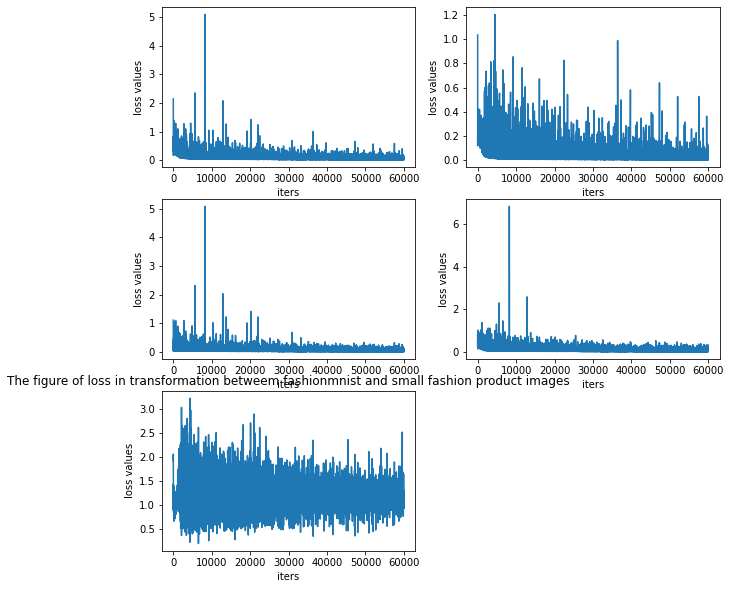

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
classes = [d_real_loss_list1,d_mnist_loss_list1,d_svhn_loss_list1,d_fake_loss_list1,g_loss_list1]
labels = ['d_real_loss','d_mnist_loss','d_svhn_loss','d_fake_loss','g_loss']
# 第一幅图的下标从1开始，设置6张子图
for plt_index in range(1,6):
    # 往画布上添加子图：按三行二列，添加到下标为plt_index的位置
    ax = fig.add_subplot(3,2,plt_index)
    # 绘制对应的子图
    plt.plot(range(train_iters+1), classes[plt_index-1], label = labels[plt_index-1])
    plt.xlabel("iters")
    plt.ylabel("loss values")
    pass

# 显示画布
plt.title("The figure of loss in transformation betweem fashionmnist and small fashion product images")
plt.show()

In [ ]:
import os, tarfile

import os
from google.colab import files

def make_targz_one_by_one(output_filename, source_dir):
  tar = tarfile.open(output_filename,"w")
  for root,dir_name,files_list in os.walk(source_dir):
    for file in files_list:
      pathfile = os.path.join(root, file)
      tar.add(pathfile)
  tar.close()
  files.download(output_filename)

make_targz_one_by_one('models_mnist_svhn.zip', '/content/models_mnist_svhn')
make_targz_one_by_one('samples_mnist_svhn.zip', '/content/samples_mnist_svhn')
make_targz_one_by_one('models_fashion.zip', '/content/models_fashion')
make_targz_one_by_one('samples_fashion.zip', '/content/samples_fashion')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>